# Context
The aim of this project is to develop a complex processing architecture capable of classifying human activities from a variety of sensor data. The dataset contains movement recordings classified into four categories: back, forward, halfsquat and still. The sensor modalities used include mainly EMG, IMU,IPS and Mocap, with the possibility of integrating other modalities if desired. The main objective is to compare a unified architecture (encompassing all modalities) with a multi-modal architecture, and to evaluate the performance of each model.

# Data preparition

Data:

* ├─1
* │  …………
* └─25

  * ├─back
  * ├─forward
  * ├─halfsquat
  * ├─still

here 1-25 is the index of each participant.


We attempted to automate the data processing workflow. We uploaded everything to the drive and created functions for extracting, segmenting, and concatenating the data. Further details about these functions will be provided in the following sections.

In [ ]:
def ensure_dataframe(file_path):
    """
    Read a CSV file if it exists; otherwise, return an empty DataFrame.
    """
    if os.path.exists(file_path):
        return pd.read_csv(file_path, index_col=0).T
    else:
        print(f"File not found: {file_path}. Returning empty DataFrame.")
        return pd.DataFrame()


def categorise_data(back_data, forward_data, halfsquat_data, still_data):

    all_data = pd.concat([back_data, forward_data, halfsquat_data, still_data], axis=0)
    # Create a list of categories based on the number of rows in each original dataframe
    num_back_rows = back_data.shape[0]
    num_forward_rows = forward_data.shape[0]
    num_halfsquat_rows = halfsquat_data.shape[0]
    num_still_rows = still_data.shape[0]

    categories = ['back'] * num_back_rows + ['forward'] * num_forward_rows + ['halfsquat'] * num_halfsquat_rows + ['still'] * num_still_rows

    # Add the 'category' column to the concatenated dataframe
    all_data['category'] = categories
    return all_data



## Sliding window

### EMG

#### Calculate RMS, WL, SSC ZC for each sliding window

In this section, we calculate the features **RMS** (Root Mean Square), **WL** (Waveform Length), **SSC** (Slope Sign Changes), and **ZC** (Zero Crossings) as described in the research paper. The functions for these calculations are presented below:


In [ ]:
import pandas as pd
import numpy as np


# Calcul des caractéristiques EMG
def compute_rms(signal):
    return np.sqrt(np.mean(signal**2))

def compute_waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def compute_slope_sign_changes(signal):
    # Compte les changements de signe de la pente
    slope = np.diff(signal)
    return np.sum(np.diff(np.sign(slope)) != 0)

def compute_zero_crossings(signal):
    # Compte les traversées de l'axe des abscisses
    return np.sum(np.diff(np.sign(signal)) != 0)

def extract_emg_features(window_data):
    features = []
    for col in ['R_Vlat', 'R_RF', 'R_ST', 'R_TA', 'L_Vlat', 'L_RF', 'L_ST', 'L_TA',
       'R_MG', 'R_LG', 'R_SOL', 'R_IL', 'L_MG', 'L_LG', 'L_SOL', 'L_IL']:
        signal = window_data[col].values

        # Calcul des 4 caractéristiques pour chaque signal EMG
        rms = compute_rms(signal)
        wl = compute_waveform_length(signal)
        ssc = compute_slope_sign_changes(signal)
        zc = compute_zero_crossings(signal)

        features.extend([rms, wl, ssc, zc])  # Ajouter les 4 caractéristiques pour chaque capteur

    return features

def sliding_window_segmentation_emg(df, window_samples, step_size):
    """
    Découpe les données en fenêtres glissantes et extrait les caractéristiques EMG.

    Args:
    - df : DataFrame contenant les données, y compris les signaux EMG et les labels (category).
    - window_samples : Taille de la fenêtre (en nombre de points).
    - step_size : Pas de glissement (en nombre de points).

    Returns:
    - segmented_df : DataFrame avec les fenêtres segmentées et les labels.
    """
    segmented_data = []

    # Assurez-vous que les catégories sont traitées séparément
    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        # Découpage des données en fenêtres
        for start in range(0, len(category_df) - window_samples + 1, step_size):
            end = start + window_samples
            window_data = category_df.iloc[start:end]

            # Extraire les caractéristiques EMG de la fenêtre
            emg_features = extract_emg_features(window_data)

            # Ajouter la catégorie de cette fenêtre
            emg_features.append(category)

            segmented_data.append(emg_features)

    # Créer un DataFrame avec les données segmentées
    column_names = [col + "_rms" for col in ['R_Vlat', 'R_RF', 'R_ST', 'R_TA', 'L_Vlat', 'L_RF', 'L_ST', 'L_TA',
       'R_MG', 'R_LG', 'R_SOL', 'R_IL', 'L_MG', 'L_LG', 'L_SOL', 'L_IL']] + \
                    [col + "_wl" for col in ['R_Vlat', 'R_RF', 'R_ST', 'R_TA', 'L_Vlat', 'L_RF', 'L_ST', 'L_TA',
       'R_MG', 'R_LG', 'R_SOL', 'R_IL', 'L_MG', 'L_LG', 'L_SOL', 'L_IL']] + \
                    [col + "_ssc" for col in ['R_Vlat', 'R_RF', 'R_ST', 'R_TA', 'L_Vlat', 'L_RF', 'L_ST', 'L_TA',
       'R_MG', 'R_LG', 'R_SOL', 'R_IL', 'L_MG', 'L_LG', 'L_SOL', 'L_IL']] + \
                    [col + "_zc" for col in ['R_Vlat', 'R_RF', 'R_ST', 'R_TA', 'L_Vlat', 'L_RF', 'L_ST', 'L_TA',
       'R_MG', 'R_LG', 'R_SOL', 'R_IL', 'L_MG', 'L_LG', 'L_SOL', 'L_IL']] + \
                    ['category']

    segmented_df = pd.DataFrame(segmented_data, columns=column_names)

    return segmented_df

### IMU et IPS

In [ ]:
import pandas as pd
import numpy as np

# Function to compute mean for IMU and IPS
def compute_mean(signal):
    return np.mean(signal)

# Function to extract features for IMU and IPS
def extract_imu_ips_features(window_data, sensors):
    features = []
    for sensor in sensors:
        signal = window_data[sensor].values
        feature = compute_mean(signal)  # Mean value for each sensor's axis
        features.append(feature)
    return features

In [ ]:
# Function for sliding window segmentation for IMU and IPS data
def sliding_window_segmentation_imu_ips(df, window_samples, step_size):

    """
    Découpe les données en fenêtres glissantes et extrait les caractéristiques EMG.

    Args:
    - df : DataFrame contenant les données, y compris les signaux EMG et les labels (category).
    - window_samples : Taille de la fenêtre (en nombre de points).
    - step_size : Pas de glissement (en nombre de points).

    Returns:
    - segmented_df : DataFrame avec les fenêtres segmentées et les labels.
    """

    segmented_data = []
    sensors = (df.columns).to_list()
    sensors.remove('category')
    # Iterate through all data and segment it based on categories
    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        # Sliding window segmentation for IMU and IPS
        for start in range(0, len(category_df) - window_samples + 1, step_size):
            end = start + window_samples
            window_data = category_df.iloc[start:end]
            # Extract IMU features
            features = extract_imu_ips_features(window_data, sensors)
            # Ajouter la catégorie de cette fenêtre
            features.append(category)
            segmented_data.append(features)

    # Create a DataFrame with the segmented data
    feature_columns = [f'{sensor}_mean' for sensor in sensors] + \
                      ['category']

    segmented_df = pd.DataFrame(segmented_data, columns=feature_columns)

    return segmented_df



### MoCap

From the doc : the mean value of re-referenced coordinates for each sensor within each sliding window was extracted as a feature.

In [ ]:
def extract_mocap_features(window_data, sensors_referenced, sensors_velocity):

    """
    Extracts motion capture (MoCap) features from a given window of data.

    Parameters:
        window_data (pd.DataFrame): A DataFrame containing sensor data for a single time window.

        sensors_referenced (list of str): A list of sensor names (excluding reference sensors)
                                          used for re-referenced coordinate features.
        sensors_velocity (list of str): A list of sensor names (including reference sensors)
                                        used for velocity-based features.

    Returns:
        list: A list of extracted features including:
              - Mean of re-referenced coordinates for each axis of each sensor in `sensors_referenced`.
              - Mean velocity for each axis of each sensor in `sensors_velocity`.
    """
    features = []

    # Re-referenced coordinate features (exclude reference sensor)
    for sensor in sensors_referenced:
        for axis in ['x', 'y', 'z']:
            signal = window_data[f'{sensor}_{axis}'].values
            features.append(np.mean(signal))  # Mean of re-referenced coordinates

    # Velocity features (include reference sensor, including IJ)
    for sensor in sensors_velocity:
        for axis in ['x', 'y', 'z']:
            signal = window_data[f'{sensor}_{axis}'].values
            velocity = np.diff(signal)  # Derivative of coordinates
            features.append(np.mean(velocity))  # Mean of velocity

    return features


In [ ]:

def sliding_window_segmentation_mocap(df, window_samples, step_size):

    """
    Performs sliding window segmentation on motion capture (MoCap) data and extracts features for each window.

    Parameters:
        df (pd.DataFrame): A DataFrame containing motion capture data.
        window_samples (int): The number of samples (rows) in each sliding window.
        step_size (int): The step size (number of rows) to move the window for the next segment.

    Returns:
        pd.DataFrame: A DataFrame where each row corresponds to the features extracted from a window,
                      and includes a 'category' column for the window's label. The columns are:
                      - Mean features for each axis of sensors in `sensors_referenced`.
                      - Mean velocity features for each axis of sensors in `sensors_velocity`.
                      - The 'category' label of the window.
    """
    segmented_data = []

    reference_sensor = 'IJ'  # Replace 'IJ' with 'C7'

    # List of available sensors (exclude '_x', '_y', '_z' duplicates)
    available_sensors = [sensor[:-2] for sensor in df.columns if sensor.endswith('_x')]

    # Separate sensors for re-referenced coordinates and velocities
    sensors_referenced = [sensor for sensor in available_sensors if sensor != reference_sensor]
    sensors_velocity = available_sensors  # Include all sensors, including IJ


    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        for start in range(0, len(category_df) - window_samples + 1, step_size):
            end = start + window_samples
            window_data = category_df.iloc[start:end]

            # Extract features
            features = extract_mocap_features(window_data, sensors_referenced, sensors_velocity)

            # Append category label
            features.append(category)
            segmented_data.append(features)

    # Feature column names
    feature_columns = [
        f'{sensor}_mean_{axis}' for sensor in sensors_referenced for axis in ['x', 'y', 'z']
    ] + [
        f'{sensor}_velocity_{axis}' for sensor in sensors_velocity for axis in ['x', 'y', 'z']
    ] + ['category']

    return pd.DataFrame(segmented_data, columns=feature_columns)


# Run data preparition

In this code, we chose to segment the data and create sliding windows for each person before concatenation. By respecting the time step and sampling rate fir each sensor :

In the document we have the following information :

    "emg": {"sampling_rate": 2000, "window_size": 0.05, "step_size": 100}, # 50s, 0.05 x 2000 for each window which gives 100 samples for each window.

    "imu": {"sampling_rate": 100, "window_size": 0.05, "step_size": 5}, # 50s, 0.05 x 100 for each window which gives 5 samples for each window.

    "ips": {"sampling_rate": 60, "window_size": 0.05, "step_size": 3}, # 50s, 0.05 x 60 for each window which gives 3 samples for each window.
    
    "mocap": {"sampling_rate": 100, "window_size": 0.05, "step_size": 5}, # 50s, 0.05 x 100 for each window which gives 5 samples for each window.

The only concatenation performed at this stage was, for instance, between emg_1 and emg_2 for each person. Throughout the process, we ensured that the category column names were preserved. Finally, we saved the processed data into separate files for each individual.

In [ ]:
import os
import re
import pandas as pd


def segment_and_save(data, segmentation_func, window_samples, step_size, save_path):
    """
    Segment the data using the specified function and save to the given path.
    """
    segmented_data = segmentation_func(data, window_samples, step_size)
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    segmented_data.to_csv(save_path)
    print(f"Saved segmented data to: {save_path}")

def process_additional_files(dataset_path, signal, categorise_data, segmentation_funcs, segmentation_params):
    """
    Detect and process additional files for a given signal in a dataset.
    """
    activities = ["back", "forward", "halfsquat", "still"]
    processed_files = set()

    # Check for additional files dynamically
    for activity in activities:
        activity_path = os.path.join(dataset_path, activity)
        if not os.path.exists(activity_path):
            continue

        for filename in os.listdir(activity_path):
            match = re.match(rf"({signal}_\d+)\.csv", filename)
            if match:
                signal_name = match.group(1)

                # Check if segmented file already exists
                segmented_file_path = os.path.join(dataset_path, "segmented_df", f"segmented_df_{signal_name}.csv")
                if os.path.exists(segmented_file_path):
                    print(f"Segmented file already exists for {signal_name}. Skipping processing.")
                    continue  # Skip if the segmented file already exists

                # Collect data for this signal across activities
                signal_data = {act: ensure_dataframe(os.path.join(dataset_path, act, f"{signal_name}.csv"))
                               for act in activities}

                # Combine and categorize
                all_data = categorise_data(
                    signal_data["back"],
                    signal_data["forward"],
                    signal_data["halfsquat"],
                    signal_data["still"]
                )

                # Get segmentation function and parameters
                params = segmentation_params.get(signal, {})
                window_samples = int(params["window_size"] * params["sampling_rate"]) # seconds * frenquence of the captor
                step_size = params["step_size"]
                save_path = os.path.join(dataset_path, "segmented_df", f"segmented_df_{signal_name}.csv")

                # Determine the segmentation function
                segmentation_func = segmentation_funcs.get(signal, None)
                if segmentation_func:
                    segment_and_save(all_data, segmentation_func, window_samples, step_size, save_path)

                processed_files.add(signal_name)

def load_dataset(num):
    """
    Load and process data for a given dataset number, including additional signal files.
    """
    dataset_path = f".../Project/data/{num}/"
    signals = ["emg", "imu", "ips", "mocap"]

    # Segmentation parameters for each signal type
    segmentation_params = {
        "emg": {"sampling_rate": 2000, "window_size": 0.05, "step_size": 100}, # for emg as mentioned in the document
        "imu": {"sampling_rate": 100, "window_size": 0.05, "step_size": 5}, # for imu //
        "ips": {"sampling_rate": 60, "window_size": 0.05, "step_size": 3}, # for ips //
        "mocap": {"sampling_rate": 100, "window_size": 0.05, "step_size": 5}, # for //
    }

    # Segmentation functions for each signal type
    segmentation_funcs = {
        "emg": sliding_window_segmentation_emg,
        "imu": sliding_window_segmentation_imu_ips,
        "ips": sliding_window_segmentation_imu_ips,
        "mocap": sliding_window_segmentation_mocap,
    }

    # Process primary files (e.g., emg_1, imu_1, etc.)
    process_additional_files(dataset_path, "emg", categorise_data, segmentation_funcs, segmentation_params)
    process_additional_files(dataset_path, "imu", categorise_data, segmentation_funcs, segmentation_params)
    process_additional_files(dataset_path, "ips", categorise_data, segmentation_funcs, segmentation_params)
    process_additional_files(dataset_path, "mocap", categorise_data, segmentation_funcs, segmentation_params)

# Run for all dataset numbers
for i in range(4, 26):
    print(f"Processing dataset {i}...")
    load_dataset(i)


Processing dataset 4...
Segmented file already exists for emg_1. Skipping processing.
Segmented file already exists for emg_1. Skipping processing.
Segmented file already exists for emg_1. Skipping processing.
Segmented file already exists for emg_1. Skipping processing.
Segmented file already exists for imu_1. Skipping processing.
Segmented file already exists for imu_1. Skipping processing.
Segmented file already exists for imu_1. Skipping processing.
Segmented file already exists for imu_1. Skipping processing.
Segmented file already exists for ips_1. Skipping processing.
Segmented file already exists for ips_1. Skipping processing.
Segmented file already exists for ips_1. Skipping processing.
Segmented file already exists for ips_1. Skipping processing.
Segmented file already exists for mocap_1. Skipping processing.
Segmented file already exists for mocap_1. Skipping processing.
Segmented file already exists for mocap_1. Skipping processing.
Segmented file already exists for mocap_

#### Concat files with multiple emgs, ips..etc, example concat emg_1 and emg_2

In [ ]:
import os
import pandas as pd

def concatenate_files_in_directory(directory_path, prefixes):
    """
    Concatenate files that match specific patterns (like segmented_df_emg_1, segmented_df_imu_1, etc.)

    :param directory_path: The directory to scan for files
    :param prefixes: List of prefixes to look for (e.g., ['segmented_df_emg', 'segmented_df_imu', 'segmented_df_ips', 'segmented_df_mocap'])
    :return: A dictionary with concatenated data for each prefix.
    """
    concatenated_data = {prefix: pd.DataFrame() for prefix in prefixes}

    # List all files in the directory
    for filename in os.listdir(directory_path):
        for prefix in prefixes:
            # Check if the filename contains the prefix and ends with .csv
            if filename.startswith(prefix) and filename.endswith(".csv"):
                file_path = os.path.join(directory_path, filename)
                # Read the file and concatenate it to the corresponding prefix dataframe
                df = pd.read_csv(file_path, index_col=0)
                concatenated_data[prefix] = pd.concat([concatenated_data[prefix], df], axis=0)
                print(f"Loaded and concatenated {filename}")

    return concatenated_data


# Example usage
directory_path = ".../Project/data/25/segmented_df/"
prefixes = ['segmented_df_emg', 'segmented_df_imu', 'segmented_df_ips', 'segmented_df_mocap']

# Call function to concatenate files
concatenated_data = concatenate_files_in_directory(directory_path, prefixes)

# Example of accessing the concatenated data for each prefix
for i in range(1, 26):
    # Call function to concatenate files
    directory_path = f".../Project/data/{i}/segmented_df/"
    concatenated_data = concatenate_files_in_directory(directory_path, prefixes)
    for prefix, data in concatenated_data.items():
        data.to_csv(f".../Project/data/{i}/segmented_df/concatenated_data_{prefix}.csv")


Loaded and concatenated segmented_df_emg_1.csv
Loaded and concatenated segmented_df_imu_1.csv
Loaded and concatenated segmented_df_ips_1.csv
Loaded and concatenated segmented_df_mocap_1.csv
Loaded and concatenated segmented_df_emg_2.csv
Loaded and concatenated segmented_df_emg_3.csv
Loaded and concatenated segmented_df_imu_2.csv
Loaded and concatenated segmented_df_imu_3.csv
Loaded and concatenated segmented_df_ips_2.csv
Loaded and concatenated segmented_df_ips_3.csv
Loaded and concatenated segmented_df_mocap_3.csv
Loaded and concatenated segmented_df_mocap_2.csv
Loaded and concatenated segmented_df_emg_1.csv
Loaded and concatenated segmented_df_imu_1.csv
Loaded and concatenated segmented_df_ips_1.csv
Loaded and concatenated segmented_df_mocap_1.csv
Loaded and concatenated segmented_df_emg_1.csv
Loaded and concatenated segmented_df_imu_1.csv
Loaded and concatenated segmented_df_ips_1.csv
Loaded and concatenated segmented_df_mocap_1.csv
Loaded and concatenated segmented_df_emg_1.csv
Loa

#### Concatenate EMG, IMU, IPS, and MoCap data for each person

In [ ]:
import os
import pandas as pd

# Base dataset path
dataset_base_path = ".../Project/data"

# File names to concatenate
file_names = [
    "concatenated_data_segmented_df_emg.csv",
    "concatenated_data_segmented_df_imu.csv",
    "concatenated_data_segmented_df_ips.csv",
    "concatenated_data_segmented_df_mocap.csv"
]

# Initialize dictionaries to store DataFrames for each file type
concatenated_data = {file_name: [] for file_name in file_names}

# Iterate through folders 1 to 25
for folder_num in range(1, 26):
    folder_path = os.path.join(dataset_base_path, str(folder_num), "segmented_df")

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            # Read CSV and add a column for the folder number
            df = pd.read_csv(file_path)
            df["person_id"] = folder_num  # Add a column for person ID
            concatenated_data[file_name].append(df)
        else:
            print(f"File not found: {file_path}")

# Concatenate all files of the same type and save
output_path = ".../Project/concatenated_data"
os.makedirs(output_path, exist_ok=True)

for file_name, dfs in concatenated_data.items():
    if dfs:  # Only process if we have data
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_file_path = os.path.join(output_path, file_name)
        combined_df.to_csv(combined_file_path, index=False)
        print(f"Saved concatenated file: {combined_file_path}")


**PS:** In the folder ../Project/concatenated_data, there are four CSV files: one for EMG, one for IMU, one for IPS, and one for MoCap. Each file contains information for all participants. As shown below, each CSV file includes two additional columns: one for **categories** and another for **patient IDs**.

In [ ]:
import pandas as pd
import os
dataset_base_path = "/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/concatenated_data"


concatenated_data_segmented_df_emg = pd.read_csv(os.path.join(dataset_base_path, "concatenated_data_segmented_df_emg.csv"), index_col=0)
concatenated_data_segmented_df_imu = pd.read_csv(os.path.join(dataset_base_path, "concatenated_data_segmented_df_imu.csv"), index_col=0)
concatenated_data_segmented_df_ips = pd.read_csv(os.path.join(dataset_base_path, "concatenated_data_segmented_df_ips.csv"), index_col=0)
concatenated_data_segmented_df_mocap = pd.read_csv(os.path.join(dataset_base_path, "concatenated_data_segmented_df_mocap.csv"), index_col=0)

In [ ]:
print(concatenated_data_segmented_df_emg.shape)
concatenated_data_segmented_df_emg.head(5)

(113446, 66)


R_Vlat_rms    R_RF_rms  R_ST_rms  R_TA_rms  L_Vlat_rms    L_RF_rms  \
0    3.154265  292.758180        65        38    3.696738  282.788085   
1    3.677968  326.696778        69        37    4.208268  287.722779   
2    3.800089  267.279053        50        26    3.798007  264.962768   
3    3.374545  292.657471        61        39    4.385206  314.007569   
4    4.138228  382.388306        64        34    3.381075  289.837644   

   L_ST_rms  L_TA_rms  R_MG_rms    R_LG_rms  ...   R_MG_zc     R_LG_zc  \
0        56        34  3.684881  195.675659  ...  3.497438  229.110718   
1        62        32  4.657688  368.994141  ...  9.854272  394.674683   
2        44        20  3.792937  284.197999  ...  5.891582  253.179930   
3        66        32  5.642971  368.893433  ...  7.399809  394.473266   
4        61        32  5.003856  253.582763  ...  6.837258  340.795900   

   R_SOL_zc  R_IL_zc   L_MG_zc     L_LG_zc  L_SOL_zc  L_IL_zc  category  \
0        51       27  3.413615  145.623779        29       21      back   
1        51       23  5.228666  243.411255        48       24      back   
2        35       12  4.752426  123.065186        34       12      back   
3        40       24  2.422399  159.622193        38       24      back   
4        52       32  4.945372  221.759034        34       22      back   

   person_id  
0          1  
1          1  
2          1  
3          1  
4          1  

[5 rows x 66 columns]

In [ ]:
print(concatenated_data_segmented_df_imu.shape)
concatenated_data_segmented_df_imu.head(5)

(113448, 56)


Head_Acc_X_mean  Head_Acc_Y_mean  Head_Acc_Z_mean  Head_Gyr_X_mean  \
0         8.904977         0.384233         4.042627        -0.011431   
1         8.932194         0.351909         4.096076         0.003090   
2         8.815747         0.335551         4.130934         0.012052   
3         8.806464         0.340593         4.196511         0.011351   
4         8.825958         0.329816         4.230514         0.006858   

   Head_Gyr_Y_mean  Head_Gyr_Z_mean  Head_Roll_mean  Head_Pitch_mean  \
0         0.014266        -0.003312      -12.650186       -10.219978   
1         0.032560         0.018453      -12.710571       -10.173904   
2         0.044186         0.031625      -12.830830       -10.102711   
3         0.028329         0.028800      -12.935340       -10.051806   
4         0.029847         0.023784      -13.026545       -10.009585   

   Head_Yaw_mean  Waist_Acc_X_mean  ...  R_F_Acc_Y_mean  R_F_Acc_Z_mean  \
0      30.065427          9.556038  ...       -1.945828        9.028294   
1      30.079566          9.562018  ...       -1.917709        9.022139   
2      30.164629          9.567548  ...       -1.950754        9.035559   
3      30.253489          9.566574  ...       -1.918910        9.035628   
4      30.324697          9.551094  ...       -1.935038        9.027972   

   R_F_Gyr_X_mean  R_F_Gyr_Y_mean  R_F_Gyr_Z_mean  R_F_Roll_mean  \
0       -0.011208        0.003525       -0.006971      10.771145   
1       -0.002480        0.000588        0.005154      10.758786   
2        0.000660        0.002772        0.008308      10.741950   
3        0.011773       -0.010301        0.003964      10.756064   
4        0.000204        0.002880        0.009668      10.757534   

   R_F_Pitch_mean  R_F_Yaw_mean  category  person_id  
0       35.535060    -17.801271      back          1  
1       35.533102    -17.822135      back          1  
2       35.548250    -17.824800      back          1  
3       35.528137    -17.802386      back          1  
4       35.522094    -17.784689      back          1  

[5 rows x 56 columns]

In [ ]:
print(concatenated_data_segmented_df_ips.shape)
concatenated_data_segmented_df_ips.head(5)

(117600, 684)


0_mean  1_mean  2_mean  3_mean  4_mean  5_mean  6_mean    7_mean  8_mean  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1.606667     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1.460000     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1.460000     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1.680000     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1.606667     0.0   

   9_mean  ...  674_mean  675_mean  676_mean  677_mean  678_mean  679_mean  \
0     0.0  ...       0.0       0.0       0.0       0.0       0.0      1.12   
1     0.0  ...       0.0       0.0       0.0       0.0       0.0      1.12   
2     0.0  ...       0.0       0.0       0.0       0.0       0.0      1.12   
3     0.0  ...       0.0       0.0       0.0       0.0       0.0      1.12   
4     0.0  ...       0.0       0.0       0.0       0.0       0.0      1.12   

   680_mean  681_mean  category  person_id  
0       0.0       0.0      back          1  
1       0.0       0.0      back          1  
2       0.0       0.0      back          1  
3       0.0       0.0      back          1  
4       0.0       0.0      back          1  

[5 rows x 684 columns]

In [ ]:
print(concatenated_data_segmented_df_mocap.shape)
concatenated_data_segmented_df_mocap.head(5)

(113448, 155)


C7_mean_x  C7_mean_y  C7_mean_z  RA_mean_x  RA_mean_y  RA_mean_z  \
0   0.182445   0.023007   1.402115   0.295875  -0.130377   1.394484   
1   0.182231   0.023087   1.402198   0.296074  -0.130325   1.394413   
2   0.182379   0.022964   1.402230   0.296210  -0.130333   1.394380   
3   0.182557   0.022945   1.402290   0.296361  -0.130337   1.394363   
4   0.182692   0.022905   1.402271   0.296523  -0.130310   1.394320   

   LA_mean_x  LA_mean_y  LA_mean_z  T8_mean_x  ...  L_LM_velocity_y  \
0   0.270495   0.187968   1.399205   0.149561  ...        -0.000554   
1   0.270739   0.188166   1.399469   0.149692  ...        -0.002312   
2   0.270884   0.188148   1.399508   0.149777  ...        -0.000166   
3   0.271069   0.188148   1.399518   0.149930  ...         0.000001   
4   0.271170   0.188165   1.399493   0.150038  ...         0.000018   

   L_LM_velocity_z  L_CAL_velocity_x  L_CAL_velocity_y  L_CAL_velocity_z  \
0        -0.000430         -0.000011      1.492492e-06         -0.000003   
1        -0.001826         -0.000012     -8.534617e-07         -0.000002   
2        -0.000142         -0.000003      1.329413e-05         -0.000004   
3         0.000015          0.000002     -9.381637e-06         -0.000010   
4         0.000024         -0.000003      7.311105e-06          0.000011   

   L_MH1_velocity_x  L_MH1_velocity_y  L_MH1_velocity_z  category  person_id  
0     -1.646624e-05     -5.342223e-06         -0.000009      back          1  
1     -8.245567e-06      2.573600e-06         -0.000001      back          1  
2     -1.418989e-06     -2.591971e-06          0.000001      back          1  
3      2.837870e-07     -4.829473e-07         -0.000006      back          1  
4     -5.972218e-06     -7.379168e-06         -0.000009      back          1  

[5 rows x 155 columns]

**As we can see, the data is not homogeneous; we have different shapes across each dataset, which could be problematic for the future training of our unified or multimodal model.**

#### Method 1

Therefore, we will select data across emg, imu, ips, and mocap datasets that has the same shape and the same sequence of categories.

In [ ]:
def verify_and_filter_datasets(emg_df, imu_df, ips_df, mocap_df):
    """
    Verifies if each person's data across emg, imu, ips, and mocap datasets
    has the same shape and the same sequence of categories. Removes inconsistent persons.

    Args:
    - emg_df, imu_df, ips_df, mocap_df: DataFrames for emg, imu, ips, and mocap datasets.

    Returns:
    - Filtered DataFrames for emg, imu, ips, and mocap with only consistent persons.
    """
    # List of datasets
    datasets = [emg_df, imu_df, ips_df, mocap_df]
    dataset_names = ['EMG', 'IMU', 'IPS', 'MOCAP']

    # Extract unique person IDs from each dataset
    person_ids = set(emg_df['person_id']).intersection(
        imu_df['person_id'], ips_df['person_id'], mocap_df['person_id']
    )

    # Valid person IDs
    valid_person_ids = []

    for person_id in person_ids:
        # Filter each dataset for the current person
        person_data = {name: df[df['person_id'] == person_id] for name, df in zip(dataset_names, datasets)}

        # Extract category sequences
        category_sequences = {name: data['category'].reset_index(drop=True) for name, data in person_data.items()}

        # Check if all category sequences are identical
        first_dataset_name = dataset_names[0]
        is_consistent = all(
            seq.equals(category_sequences[first_dataset_name])
            for seq in category_sequences.values()
        )

        # Check if all datasets have the same number of rows for the person
        is_same_shape = all(
            len(person_data[name]) == len(person_data[first_dataset_name])
            for name in dataset_names
        )

        if is_consistent and is_same_shape:
            valid_person_ids.append(person_id)

    # Filter each dataset to include only valid persons
    filtered_datasets = [df[df['person_id'].isin(valid_person_ids)] for df in datasets]

    return tuple(filtered_datasets), valid_person_ids  # Return filtered datasets


# Example usage:
filtered_datasets, valid_person_ids = verify_and_filter_datasets(
    concatenated_data_segmented_df_emg,
    concatenated_data_segmented_df_imu,
    concatenated_data_segmented_df_ips,
    concatenated_data_segmented_df_mocap
)

# Display the results
print("People kept :", valid_person_ids)
print("Filtered EMG shape:", filtered_datasets[0].shape)
print("Filtered IMU shape:", filtered_datasets[1].shape)
print("Filtered IPS shape:", filtered_datasets[2].shape)
print("Filtered MOCAP shape:", filtered_datasets[3].shape)

People kept : [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]
Filtered EMG shape: (99364, 66)
Filtered IMU shape: (99364, 56)
Filtered IPS shape: (99364, 684)
Filtered MOCAP shape: (99364, 155)


In [ ]:
dataset_base_path = ".../Project/dataset/method_1/"
filtered_datasets[0].to_csv(os.path.join(dataset_base_path, "filtered_datasets_emg.csv"))
filtered_datasets[1].to_csv(os.path.join(dataset_base_path, "filtered_datasets_imu.csv"))
filtered_datasets[2].to_csv(os.path.join(dataset_base_path, "filtered_datasets_ips.csv"))
filtered_datasets[3].to_csv(os.path.join(dataset_base_path, "filtered_datasets_mocap.csv"))

In [ ]:
minimum_data_to_be_used = 113446
new_used_data = 99364

percentage_change = ((minimum_data_to_be_used-new_used_data) / minimum_data_to_be_used) * 100

print(f"The percentage of deleted data is: {percentage_change:.2f}%")

The percentage of deleted data is: 12.41%


#### Method 2

**Truncating Excess Data**

If the IPS contains more data over a given period (e.g., due to differing recording durations or uneven sampling rates):

  For example, if the EMG and IMU cover 10 seconds of recording, retain only the first 10 seconds of IPS data.

In [ ]:
import pandas as pd

def align_person_data(emg_df, imu_df, ips_df, mocap_df):
    """
    Align data for each person and category based on the minimum number of rows
    for each (category, person_id) combination across all datasets (EMG, IMU, IPS, MOCAP).

    Args:
    - emg_df, imu_df, ips_df, mocap_df: DataFrames for EMG, IMU, IPS, and MOCAP datasets.

    Returns:
    - Aligned DataFrames for EMG, IMU, IPS, and MOCAP for each person.
    """
    # List of datasets and their names
    datasets = [emg_df, imu_df, ips_df, mocap_df]
    dataset_names = ['EMG', 'IMU', 'IPS', 'MOCAP']

    # Extract unique person IDs from all datasets
    person_ids = set(emg_df['person_id']).intersection(
        imu_df['person_id'], ips_df['person_id'], mocap_df['person_id']
    )

    # Prepare aligned datasets
    aligned_datasets = {name: [] for name in dataset_names}

    for person_id in person_ids:
        # Filter each dataset for the current person
        person_data = {name: df[df['person_id'] == person_id] for name, df in zip(dataset_names, datasets)}

        # Get all unique (category, person_id) pairs for this person
        unique_combinations = pd.concat([
            df[['category', 'person_id']] for df in person_data.values()
        ]).drop_duplicates()

        # Align data for each (category, person_id) combination
        for _, (category, _) in unique_combinations.iterrows():
            # Filter each dataset for this category and person
            filtered_data = {
                name: data[(data['category'] == category)] for name, data in person_data.items()
            }

            # Get the minimum number of rows for this (category, person_id) pair
            min_rows = min(len(data) for data in filtered_data.values())

            # Take the first min_rows rows for each dataset
            for name, data in filtered_data.items():
                aligned_datasets[name].append(data.head(min_rows))

    # Concatenate aligned data for each dataset
    final_datasets = {name: pd.concat(data_list) for name, data_list in aligned_datasets.items()}

    return final_datasets['EMG'], final_datasets['IMU'], final_datasets['IPS'], final_datasets['MOCAP']


# Example usage:
aligned_emg, aligned_imu, aligned_ips, aligned_mocap = align_person_data(
    concatenated_data_segmented_df_emg,
    concatenated_data_segmented_df_imu,
    concatenated_data_segmented_df_ips,
    concatenated_data_segmented_df_mocap
)

# Display the results
print("Aligned EMG shape:", aligned_emg.shape)
print("Aligned IMU shape:", aligned_imu.shape)
print("Aligned IPS shape:", aligned_ips.shape)
print("Aligned MOCAP shape:", aligned_mocap.shape)


Aligned EMG shape: (113446, 66)
Aligned IMU shape: (113446, 56)
Aligned IPS shape: (113446, 684)
Aligned MOCAP shape: (113446, 155)


In [ ]:
def verify_sequence(df1, df2, col1, col2):
    """
    Verifies if the sequence of combinations of two columns in df1
    appears in the same order in df2.

    Parameters:
    df1 (pd.DataFrame): First DataFrame to check against.
    df2 (pd.DataFrame): Second DataFrame containing the sequence to verify.
    col1 (str): The name of the first column to check.
    col2 (str): The name of the second column to check.

    Returns:
    bool: True if the sequence of combinations from df1 appears in df2 in the same order, False otherwise.
    """
    # Extract combinations (tuples) of col1 and col2 from both dataframes
    df1_combinations = list(zip(df1[col1], df1[col2]))
    df2_combinations = list(zip(df2[col1], df2[col2]))

    # Check if df1's combinations are a subsequence of df2's combinations
    idx = 0
    for comb in df1_combinations:
        try:
            # Find the next occurrence of the combination in df2
            idx = df2_combinations.index(comb, idx)
        except ValueError:
            print(comb, idx)
            return False
        # Move to the next index after the current match
        idx += 1

    return True


In [ ]:

# Call the function with the desired columns
result = verify_sequence(aligned_emg, aligned_imu, 'category', 	'person_id')
print(result)  # Output: True (since the combination (1, 'a'), (2, 'b'), (3, 'c') appears in order in df2)

True


In [ ]:

# Call the function with the desired columns
result = verify_sequence(aligned_emg, aligned_ips, 'category', 	'person_id')
print(result)  # Output: True (since the combination (1, 'a'), (2, 'b'), (3, 'c') appears in order in df2)

True


In [ ]:

# Call the function with the desired columns
result = verify_sequence(aligned_emg, aligned_mocap, 'category', 	'person_id')
print(result)  # Output: True (since the combination (1, 'a'), (2, 'b'), (3, 'c') appears in order in df2)

True


In [ ]:
dataset_base_path = "/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/dataset/method_2/" # use the fulle path if you want to run it
aligned_emg.to_csv(os.path.join(dataset_base_path, "aligned_datasets_emg.csv"))
aligned_imu.to_csv(os.path.join(dataset_base_path, "aligned_datasets_imu.csv"))
aligned_ips.to_csv(os.path.join(dataset_base_path, "aligned_datasets_ips.csv"))
aligned_mocap.to_csv(os.path.join(dataset_base_path, "aligned_datasets_mocap.csv"))



**PS** : If you're willing to run the notebook you'll need to replace ataset_base_path = ".../Project/dataset/method_2/" by the full path

# EDA without segmentaiton

## Load dataset

In [ ]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')

# path
raw_files = [
    '/content/drive/My Drive/concatenated/emg_all_participants.csv',
    '/content/drive/My Drive/concatenated/imu_all_participants.csv',
    '/content/drive/My Drive/concatenated/ips_all_participants.csv',
    '/content/drive/My Drive/concatenated/mocap_all_participants.csv'
]


# Load dataset
def load_datasets(file_paths):
    datasets = {}
    for file_path in file_paths:
        try:
            # Extract the key part of the filename as a dictionary key
            dataset_name = file_path.split('/')[-1].split('_')[0]
            df = pd.read_csv(file_path)
            datasets[dataset_name] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return datasets


raw_datasets = load_datasets(raw_files)


dataset_info = [{"Dataset Name": name, "Shape": df.shape, "Rows": df.shape[0], "Columns": df.shape[1]}
                for name, df in raw_datasets.items()]
dataset_info_df = pd.DataFrame(dataset_info)

print(dataset_info_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Dataset Name           Shape      Rows  Columns
0          emg  (11348420, 18)  11348420       18
1          imu    (567439, 56)    567439       56
2          ips   (352872, 684)    352872      684
3        mocap    (567439, 80)    567439       80


In [ ]:
emg_df = raw_datasets["emg"]
print(emg_df.head())

     R_Vlat      R_RF      R_ST       R_TA    L_Vlat      L_RF      L_ST  \
0 -0.704956  1.309204 -2.316284 -20.242310 -6.747437  2.920532 -1.208496   
1  2.014160  1.309204 -2.316284 -16.415405 -1.208496  2.618408 -1.208496   
2 -0.704956  1.309204 -2.316284 -16.314697 -1.107788  1.107788 -1.208496   
3 -0.704956  1.309204 -2.316284 -12.387085 -2.316284 -1.913452 -1.208496   
4 -0.704956  1.309204 -2.316284 -11.581421  1.208496 -2.618408 -1.208496   

       L_TA      R_MG       R_LG      R_SOL    R_IL      L_MG       L_LG  \
0 -6.948853 -0.906372 -12.387085  54.180908 -2.5177 -0.704956  10.876465   
1 -6.948853 -0.906372 -12.387085  54.180908 -2.5177 -0.704956  10.876465   
2 -6.948853 -0.906372 -12.387085  54.180908 -2.5177 -0.704956  10.876465   
3 -6.948853 -0.906372 -12.387085  54.180908 -2.5177 -0.704956  10.876465   
4 -6.948853 -0.906372 -12.387085  54.180908 -2.5177 -0.704956  10.876465   

     L_SOL     L_IL  people_id category  
0 -3.52478 -3.52478          1     back  
1 

In [ ]:
imu_df = raw_datasets["imu"]
print(imu_df.head())

   Head_Acc_X  Head_Acc_Y  Head_Acc_Z  Head_Gyr_X  Head_Gyr_Y  Head_Gyr_Z  \
0    8.902975    0.412529    4.052022   -0.015015    0.010260   -0.009929   
1    8.912331    0.391603    4.045956   -0.010874    0.014445   -0.006227   
2    8.889990    0.384217    4.039017   -0.013686    0.012110   -0.005442   
3    8.904131    0.372749    4.011355   -0.011734    0.018341   -0.003756   
4    8.915459    0.360066    4.064784   -0.005845    0.016175    0.008792   

   Head_Roll  Head_Pitch   Head_Yaw  Waist_Acc_X  ...  R_F_Acc_Y  R_F_Acc_Z  \
0 -12.639535  -10.234849  30.077293     9.578385  ...  -1.903201   9.019931   
1 -12.643968  -10.226859  30.069993     9.540294  ...  -1.942165   9.052294   
2 -12.647921  -10.220573  30.063655     9.561864  ...  -1.965231   9.028006   
3 -12.654819  -10.211424  30.056963     9.566546  ...  -1.979159   9.013625   
4 -12.664689  -10.206186  30.059231     9.533102  ...  -1.939386   9.027615   

   R_F_Gyr_X  R_F_Gyr_Y  R_F_Gyr_Z   R_F_Roll  R_F_Pitch    R_

In [ ]:
ips_df = raw_datasets["ips"]
print(ips_df.head())

     0    1    2    3    4    5    6     7    8    9  ...  674  675  676  677  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.68  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.46  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.68  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.46  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.46  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   678   679  680  681  people_id  category  
0  0.0  1.12  0.0  0.0          1      back  
1  0.0  1.12  0.0  0.0          1      back  
2  0.0  1.12  0.0  0.0          1      back  
3  0.0  1.12  0.0  0.0          1      back  
4  0.0  1.12  0.0  0.0          1      back  

[5 rows x 684 columns]


In [ ]:
mocap_df = raw_datasets["mocap"]
print(mocap_df.head())

       IJ_x      IJ_y      IJ_z      C7_x      C7_y      C7_z      RA_x  \
0  0.360232  0.036676  1.339469  0.182676  0.022713  1.402011  0.295808   
1  0.360224  0.036675  1.339442  0.182736  0.022733  1.402016  0.295852   
2  0.360238  0.036663  1.339396  0.182752  0.022742  1.402047  0.295857   
3  0.360245  0.036648  1.339374  0.182005  0.023425  1.402234  0.295907   
4  0.360242  0.036649  1.339332  0.182054  0.023421  1.402266  0.295949   

       RA_y      RA_z      LA_x  ...    L_LM_y    L_LM_z   L_CAL_x   L_CAL_y  \
0 -0.130378  1.394512  0.270449  ...  0.230522  0.097288  0.175458  0.150199   
1 -0.130367  1.394480  0.270494  ...  0.230771  0.097520  0.175447  0.150244   
2 -0.130383  1.394484  0.270543  ...  0.230781  0.097522  0.175443  0.150229   
3 -0.130379  1.394480  0.270465  ...  0.229892  0.096819  0.175402  0.150215   
4 -0.130379  1.394464  0.270525  ...  0.228305  0.095568  0.175413  0.150205   

    L_CAL_z   L_MH1_x   L_MH1_y   L_MH1_z  people_id  category  
0  

In [ ]:
print(emg_df.dtypes)


R_Vlat       float64
R_RF         float64
R_ST         float64
R_TA         float64
L_Vlat       float64
L_RF         float64
L_ST         float64
L_TA         float64
R_MG         float64
R_LG         float64
R_SOL        float64
R_IL         float64
L_MG         float64
L_LG         float64
L_SOL        float64
L_IL         float64
people_id      int64
category      object
modality      object
dtype: object


## General analysis

#### Class distribution across modalities

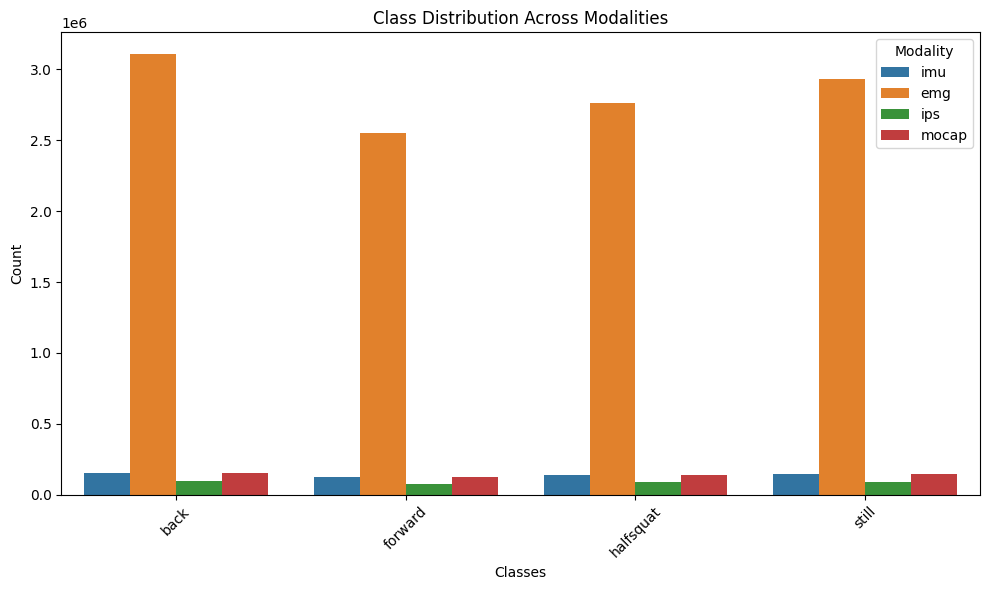

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data in DataFrame imu_df, emg_df, ips_df, mocap_df

imu_df['modality'] = 'imu'
emg_df['modality'] = 'emg'
ips_df['modality'] = 'ips'
mocap_df['modality'] = 'mocap'



all_data = pd.concat([imu_df, emg_df, ips_df, mocap_df], ignore_index=True)


if "category" not in all_data.columns:
    print("Error: 'category' column is missing in the combined dataset.")


plt.figure(figsize=(10, 6))
sns.countplot(data=all_data, x="category", hue="modality")
plt.title("Class Distribution Across Modalities")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.legend(title="Modality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


#raw_datasets = {"emg": emg_df, "imu": imu_df, "ips": ips_df, "mocap": mocap_df}

def plot_class_distribution(dataset_name, df):
    """
    Plotting category distribution histograms and pie charts
    :param dataset_name: dataset name
    :param df: dataset DataFrame
    """
    #  Distribution of statistical categories
    class_counts = df['category'].value_counts()

    #  Plotting bar charts
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title(f"Class Distribution in {dataset_name}")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # pie charts
    plt.figure(figsize=(7, 7))
    class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
    plt.title(f"Class Proportion in {dataset_name}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


for dataset_name, df in raw_datasets.items():
    print(f"Analyzing {dataset_name} dataset:")
    print(df['category'].value_counts())
    #plot_class_distribution(dataset_name, df)


Analyzing emg dataset:
category
back         3105265
still        2930170
halfsquat    2762361
forward      2550624
Name: count, dtype: int64
Analyzing imu dataset:
category
back         155268
still        146518
halfsquat    138119
forward      127534
Name: count, dtype: int64
Analyzing ips dataset:
category
back         97567
halfsquat    88692
still        87905
forward      78708
Name: count, dtype: int64
Analyzing mocap dataset:
category
back         155268
still        146517
halfsquat    138119
forward      127535
Name: count, dtype: int64


#### Modality distributions

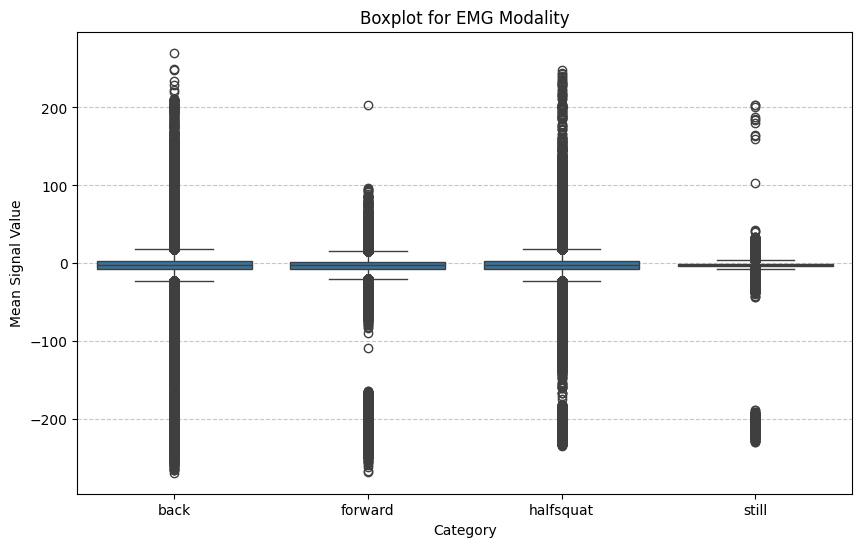

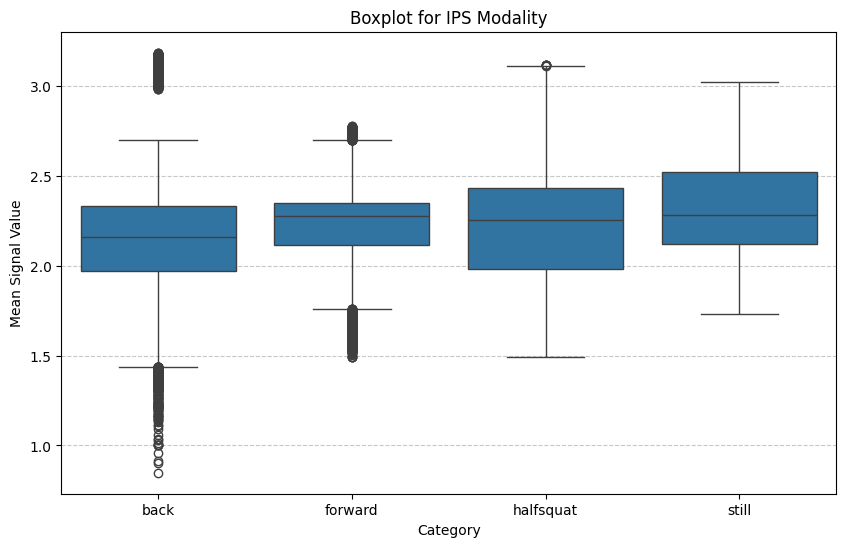

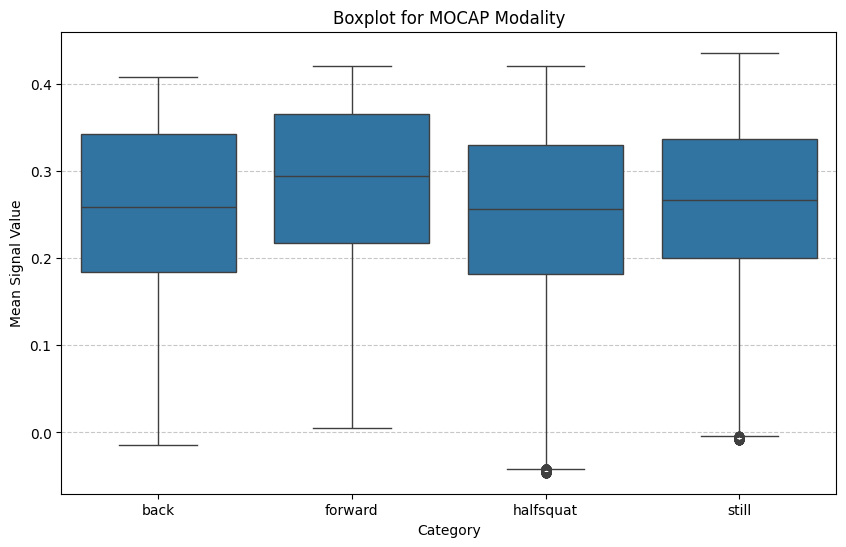

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting individual modal distributions
def plot_modality_distributions(modality_name, df):
    """
    Plotting the distribution of categories for a single modality (box-and-line plot)
    :param modality_name: modality name (string)
    :param df: dataset DataFrame (with people_id and category columns)
    """

    df['mean_signal'] = df.drop(['people_id', 'category','modality'], axis=1).mean(axis=1)

    # box-and-line diagram
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='category', y='mean_signal')
    plt.title(f"Boxplot for {modality_name} Modality")
    plt.xlabel("Category")
    plt.ylabel("Mean Signal Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_modality_distributions("EMG", emg_df)
plot_modality_distributions("IMU", imu_df)
plot_modality_distributions("IPS", ips_df)
plot_modality_distributions("MOCAP", mocap_df)



The boxplot of the EMG modal shows the distribution of the mean signal values for each category. It can be observed that the back and halfsquat categories have a large range of data, while forward and still have a relatively small range.

The signals in the back and halfsquat categories contain a large number of high amplitude outliers, which may be caused by violent movements or fluctuations in the measurement equipment.


IMU Modal Analysis
The distribution of signal values in IMU modes is extremely concentrated, with the majority of signals symmetrically distributed around zero.
Extreme outliers exist, such as values up to 8000 in the still category.

There is consistency in the distribution between categories, with the medians and ranges of all categories being very similar except for a few outliers, suggesting that the IMU signal may be less discriminating between different action categories.
IPS modal analysis:

Box plots of the IPS modality show significant differences between categories
The wider range of signals in the halfsquat, back, and still categories may indicate that these actions have a more complex effect on the pressure distribution.
The forward category has a relatively narrow range, but also contains some higher outliers.
The relatively high median for the still category may correspond to a stable pressure distribution during the maneuver, while the forward category has a relatively low median.

MoCap Mode Analysis

The signal distribution of the MoCap mode is very uniform, with highly consistent medians and ranges across all categories, suggesting that the effect of the action on the mode is stable.
There are a few outliers in each category, but the range is within reasonable limits.

The EMG and IPS modes have a greater potential for category differentiation.
The high amplitude variability of EMG and the clear category differences of IPS suggest that these two modalities may have greater discriminative power in categorization tasks.

The IMU and MoCap modes are less discriminative, the signal distributions of IMU and MoCap are more consistent, and may need to be combined with other modes or further feature extraction to enhance the discriminative ability.

There are obvious outliers in all modalities, which may adversely affect the training and prediction of the model and need to be further dealt with.



#### Density distribution

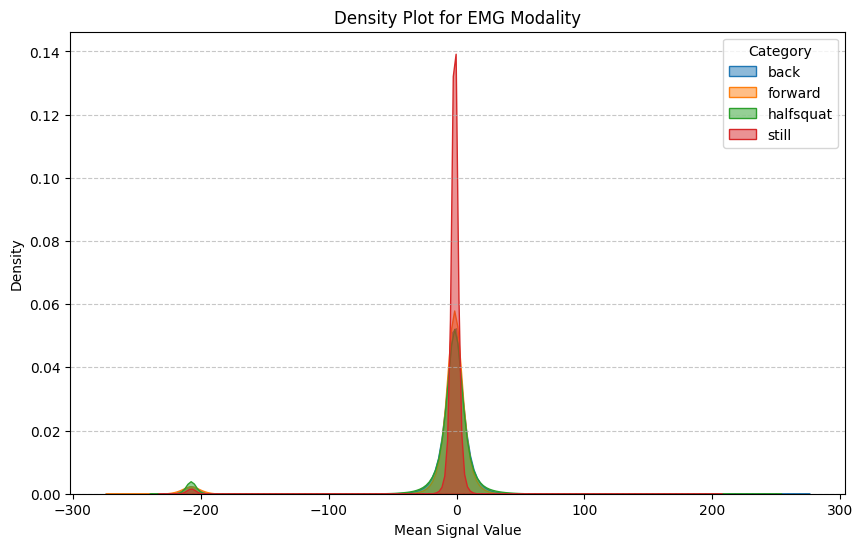

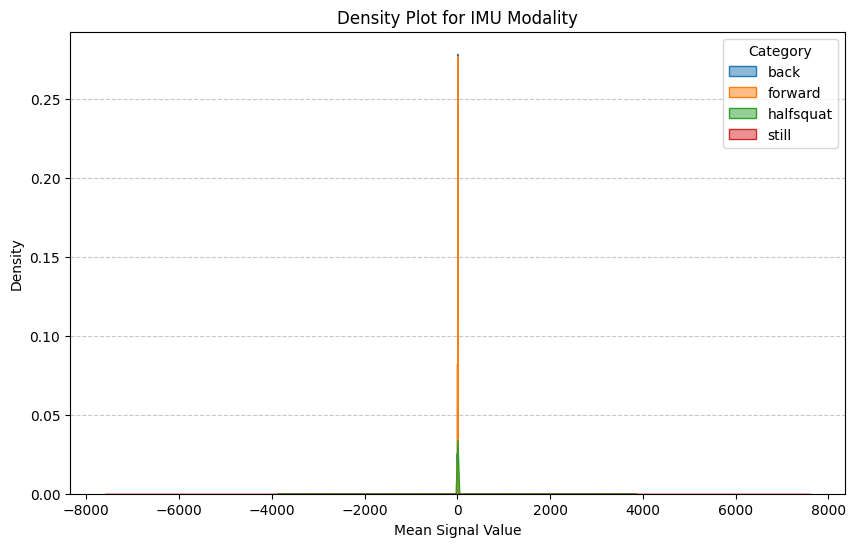

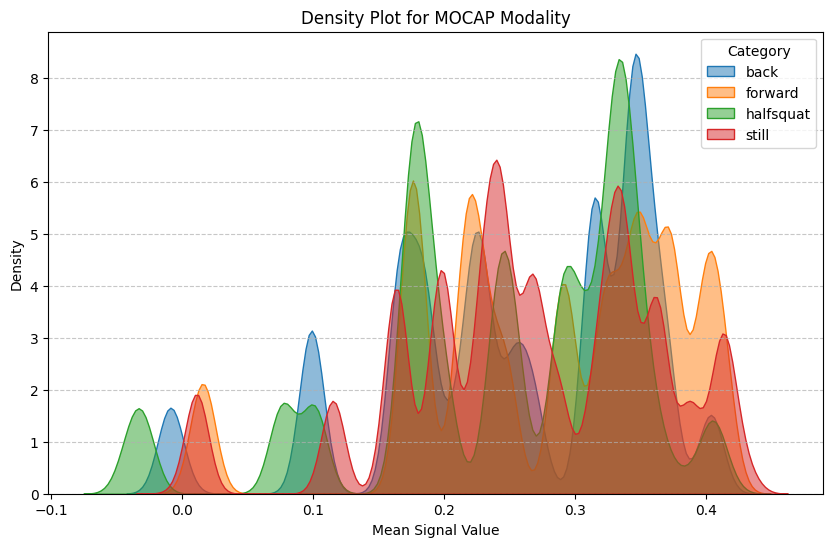

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting density map functions for individual modes
def plot_density_by_modality(modality_name, df):
    """
    Plotting the density distribution of a single modality
    :param modality_name: modality name (string)
    :param df: dataset DataFrame (with people_id and category columns)
    """
    # Calculate the signal mean for each row, excluding non-numeric columns
    df['mean_signal'] = df.drop(['people_id', 'category','modality'], axis=1).mean(axis=1)


    plt.figure(figsize=(10, 6))
    for category in df['category'].unique():
        subset = df[df['category'] == category]['mean_signal']
        sns.kdeplot(
            subset,
            label=category,
            fill=True,
            alpha=0.5
        )
    plt.title(f"Density Plot for {modality_name} Modality")
    plt.xlabel("Mean Signal Value")
    plt.ylabel("Density")
    plt.legend(title="Category")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


plot_density_by_modality("EMG", emg_df)
plot_density_by_modality("IMU", imu_df)
plot_density_by_modality("IPS", ips_df)
plot_density_by_modality("MOCAP", mocap_df)


These density plots show the signal distribution characteristics of each category under different modal EMG, IMU, IPS, and MOCAP, from which this information can be observed:

1. EMG modal analysis
The density distribution of the signal values in the plots exhibits a very strong peak around 0, which indicates that most of the EMG data is concentrated in the low amplitude region.
The differences between categories are not significant, but a small number of abnormal signal values (e.g., greater than 200 or less than -200) can be observed.
The EMG signal is an important indication of muscle activity, and although the signal is concentrated, dynamic movements such as back (back) versus halfsquat (halfsquat) may show potentially distinguishing features in the tail region of the distribution, which is of research value for classification tasks.

2. IMU modal analysis
Signal densities were concentrated around 0 with significant outliers (e.g., greater than 7000 or less than -8000).
There is no significant difference in the distribution between categories.
Most of the dynamic features of the IMU signals may be normalized to outliers, suggesting that signal normalization or feature extraction may need further optimization; IMU signals may be more useful for capturing a wide range of dynamic motions.

3. IPS Modal Analysis
The distribution of the signals is mainly concentrated between 1.5 and 3, with some overlap among the four categories, but slight differences in the locations of the peaks of the categories can be observed (e.g., forward is around 2.5 and still is around 2.8).
The distribution of the categories is clearly separated, indicating that the IPS signal has a better ability to distinguish between different motion states.
The IPS modality captures better category separation, which may be more informative especially in fine-motion categorization or when the motion amplitude is small (e.g., still and forward).

4. MOCAP modal analysis
The density distributions of the signal values showed multi-peak characteristics, and there were obvious differences in some of the peak locations between different categories, e.g., the signal distributions of back and halfsquat overlapped significantly around 0.2 and 0.3.
The multiple peaks indicate that the MOCAP data can reflect the complex motion characteristics.
The signal distribution of MOCAP is suitable for the study of the complex dynamic characteristics of different motion postures, such as the extraction of time series features in dynamic posture recognition.


## Temporal visualisation for person with id 1



### EMG

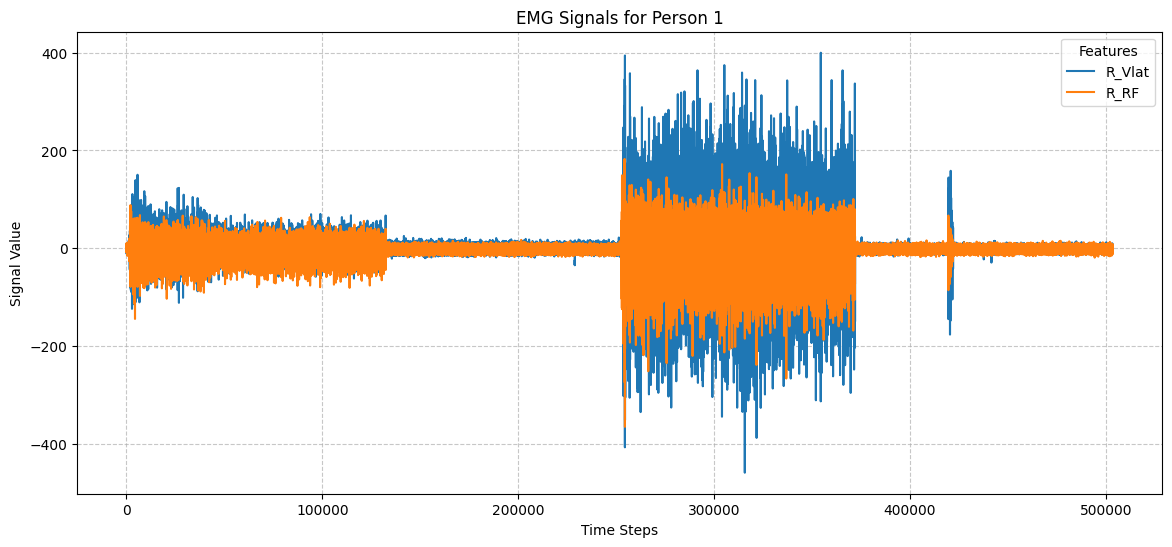

In [ ]:
# people_id = 1
emg_person1 = emg_df[emg_df['people_id'] == 1]

# features R_Vlat, R_RF
emg_features = ['R_Vlat', 'R_RF']


plt.figure(figsize=(14, 6))
for feature in emg_features:
    plt.plot(emg_person1.index, emg_person1[feature], label=feature)
plt.title("EMG Signals for Person 1")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Here we have chosen two muscles of the right leg R_Vlat (right lateral femoral) and R_RF (right rectus femoris) R_Vlat and R_RF are both important muscles of the lower limb, responsible for the extension movements of the knee joint, which change significantly during dynamic movements (e.g., walking, running, and deep squatting). From the figure, we both can observe that the overall trend of the two signals is relatively consistent.
The overall trend of the two signals is relatively consistent, but the fluctuation amplitude is different, which may be related to the functional differences between the two muscles.

In [ ]:

plt.figure(figsize=(12, 6))

# R_Vlat
plt.subplot(2, 1, 1)
plt.plot(emg_person1.index, emg_person1['R_Vlat'], color='blue', label='R_Vlat')
plt.title('EMG Signal for R_Vlat')
plt.xlabel('Time Steps')
plt.ylabel('Signal Value')
plt.grid()
plt.legend()

# L_Vlat
plt.subplot(2, 1, 2)
plt.plot(emg_person1.index, emg_person1['L_Vlat'], color='orange', label='L_Vlat')
plt.title('EMG Signal for L_Vlat')
plt.xlabel('Time Steps')
plt.ylabel('Signal Value')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Here we have selected the symmetrical right leg lateral femoral muscle and the left leg lateral femoral muscle. We can observe that the signal amplitude is lower in the right leg, with an overall fluctuation range of about -400 to 400. The left leg has a higher fluctuation range, even exceeding 1000 at some stages.

Symmetry and coordination analysis of the two signals show similar temporal trends, suggesting that the left and right legs are coordinated in their movements in time.
However, the difference in amplitude suggests that there may be asymmetric force distribution or movement characteristics at some stages.
The signal amplitude of R_Vlat was overall lower than that of L_Vlat, suggesting that the left leg may have carried more load during the movement.
During high-intensity maneuvers (after 300,000 time steps), the activation intensity of L_Vlat was much higher than that of R_Vlat, which may be related to the asymmetry of the maneuver or the dominant characteristics of the left leg.


In [ ]:
for category in emg_person1['category'].unique():
    subset = emg_person1[emg_person1['category'] == category]
    plt.plot(subset.index, subset['R_Vlat'], label=f"R_Vlat ({category})")
plt.title("EMG Signal for R_Vlat by Category")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Here we chose to categorize the right lateral femoral muscle signals, and the figure shows the time series distribution of R_Vlat signals under different categories (back, forward, halfsquat, still).
The back and forward phases have low amplitude and are relatively smooth, indicating that these movements have a low level of activation of the R_Vlat.
The halfsquat phase signals fluctuated dramatically in amplitude and increased significantly in range, suggesting that stronger lateral femoral activation was required for this maneuver.
The still phase signal regression is smooth and low in amplitude, indicating that the muscle is at rest during this phase.
Inter-category differences:
The amplitude and range of fluctuations of the signals in each category are clearly visible, suggesting that R_Vlat is a very important feature in movement categorization.

### IMU

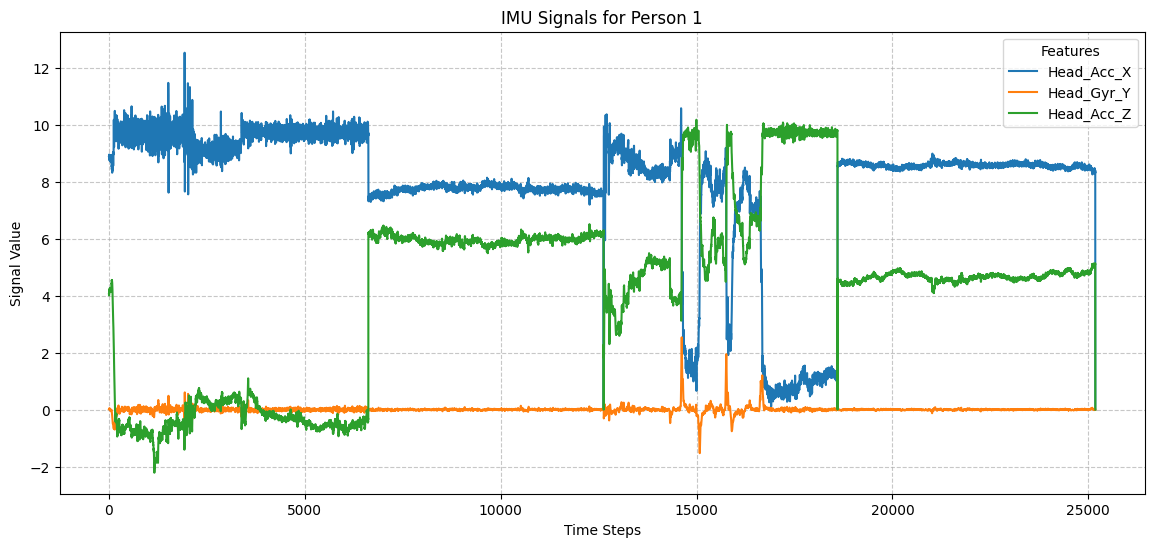

In [ ]:

imu_person1 = imu_df[imu_df['people_id'] == 1]

imu_features = ['Head_Acc_X', 'Head_Gyr_Y', 'Head_Acc_Z']


plt.figure(figsize=(14, 6))
for feature in imu_features:
    plt.plot(imu_person1.index, imu_person1[feature], label=feature)
plt.title("IMU Signals for Person 1")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()



First we selected the data Head_Acc_X, Head_Acc_Z, and Head_Gyr_Y for the person 1 IMU sensor head information.
Head_Acc_X reflects the linear motion in the horizontal forward and backward directions.
Head_Gyr_Y captures angular velocity characteristics in the rotational direction.
Head_Acc_Z captures motion in the vertical direction, supplemented by changes in gravitational acceleration.
Head_Acc_X, Head_Acc_Z, and Head_Gyr_Y show significant fluctuations over multiple time periods, indicating strong dynamic motion in these directions.

We can observe the trend of motion switching in the graphs. Around 5000, 10000, and 15000, we can observe a sudden change or a smooth recovery of the signal, which may correspond to the start, switch, or end of the motion.
Around 15000, Head_Acc_X decreases significantly, indicating a possible deceleration or completion of the action.
The steady state is a smoother signal in the 0-5000 and 20000-25000 timeframes, indicating less movement and possibly a stationary or slow-moving state.
In terms of directional differences, the amplitude change of Head_Acc_X is greater, indicating that movement in the X direction is the main component.
The change in Head_Gyr_Y is relatively flat, indicating that the rotational angular velocity may not be as significant as the linear acceleration.

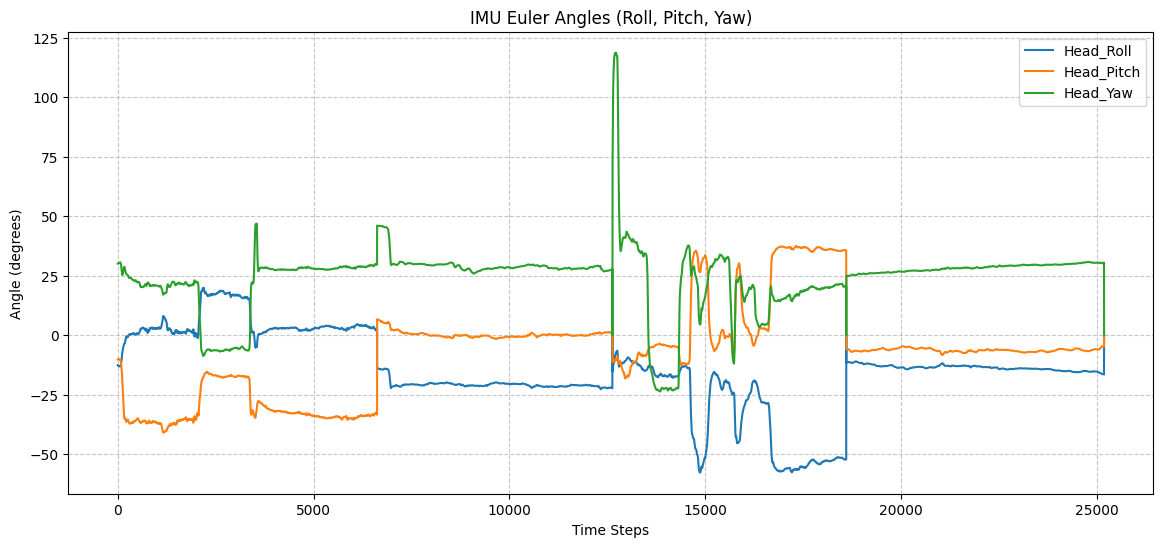

In [ ]:
# Euler Angles: Roll, Pitch, Yaw
euler_features = ['Head_Roll', 'Head_Pitch', 'Head_Yaw']
plt.figure(figsize=(14, 6))
for feature in euler_features:
    plt.plot(imu_person1.index, imu_person1[feature], label=feature)
plt.title("IMU Euler Angles (Roll, Pitch, Yaw)")
plt.xlabel("Time Steps")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Here we choose Roll, Pitch, and Yaw as the three features of the Euler angles of the first human head, because these three features can describe the posture of the head in 3D space comprehensively, which is very important for analyzing the stability of the posture and the dynamic movements.

The angles of Head_Roll, Head_Pitch, and Head_Yaw fluctuate significantly over time.
At certain points in time, such as around 15000, there are large angle jumps, which may reflect rapid pose switches or movement shifts.
Stability and anomalies:

In some segments (e.g., 6000-12000 and after 20000), the changes in Roll, Pitch, and Yaw were small, suggesting a more stable body posture.
Around 15000, there are large spikes in Yaw, which may be due to fast rotational movements captured by the sensor or data noise.
In terms of postural characteristics, the overall changes in Head_Roll and Head_Pitch are relatively smooth, which may be associated with forward, backward, or sideways tilting movements of the body.
Yaw changes are significant, indicating a significant rotational component to the movement.


### IPS

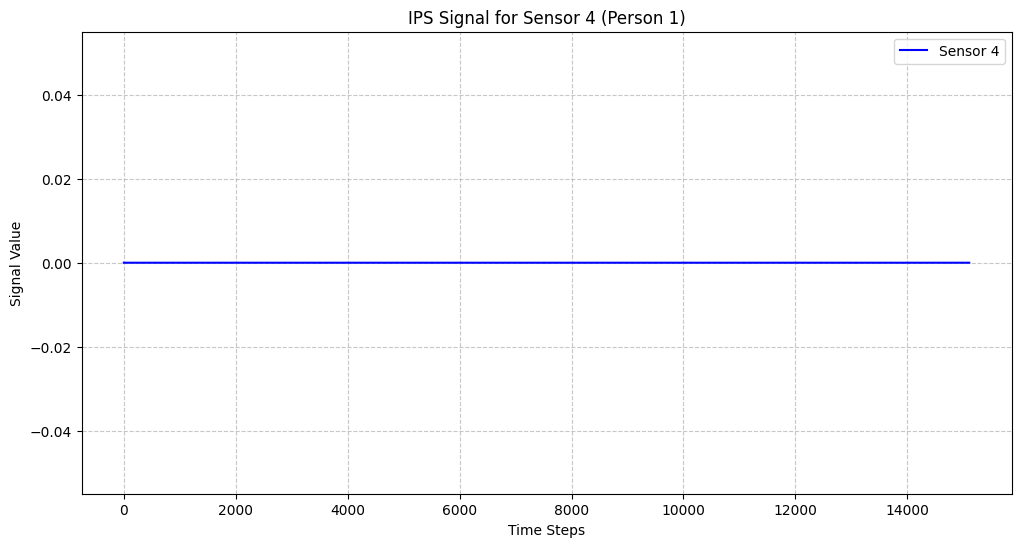

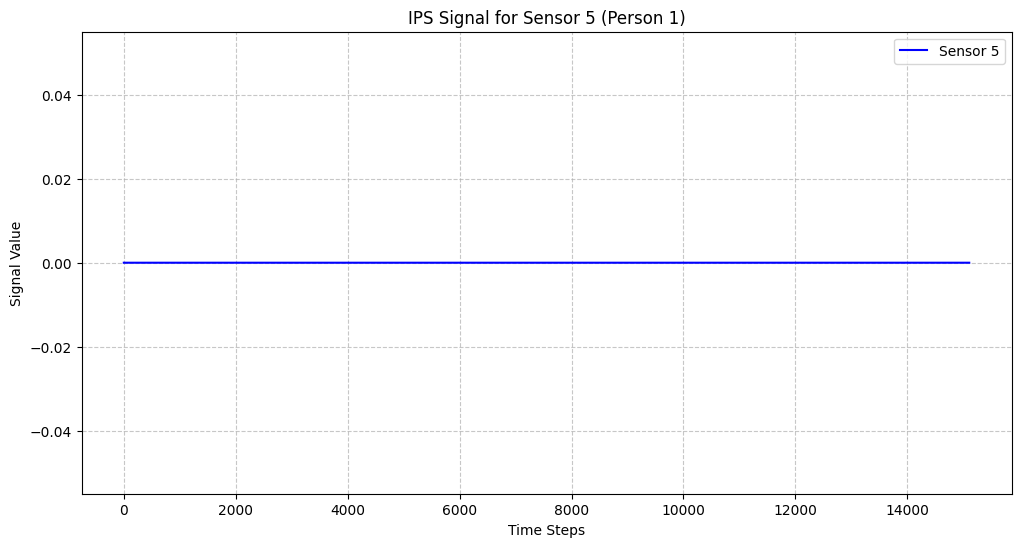

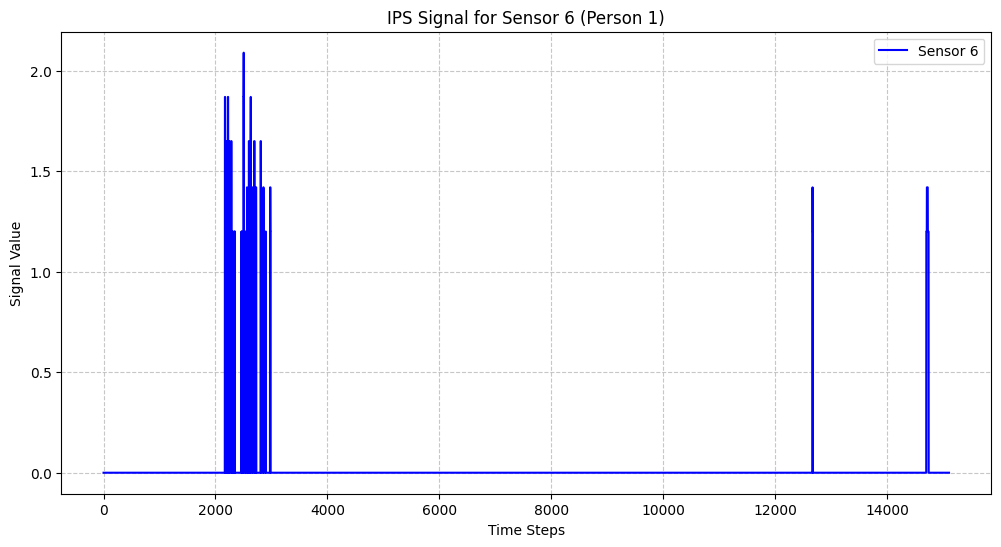

In [ ]:
import matplotlib.pyplot as plt


ips_person1 = ips_df[ips_df['people_id'] == 1]

# Selection feature of columns
ips_features = [ 4, 5, 6]


for feature in ips_features:
    plt.figure(figsize=(12, 6))
    plt.plot(ips_person1.index, ips_person1.iloc[:, feature], label=f"Sensor {feature}", color='b')
    plt.title(f"IPS Signal for Sensor {feature} (Person 1)")
    plt.xlabel("Time Steps")
    plt.ylabel("Signal Value")
    plt.legend(loc="upper right")
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.show()


IPS data is collected from sensors on the sole of the foot or in the insole, and the location of different sensors may affect the signal characteristics. At rest, there may be no significant pressure on the toes, while the 6th sensor maybe in the center of the foot may be subject to more pressure changes.


### MOCAP

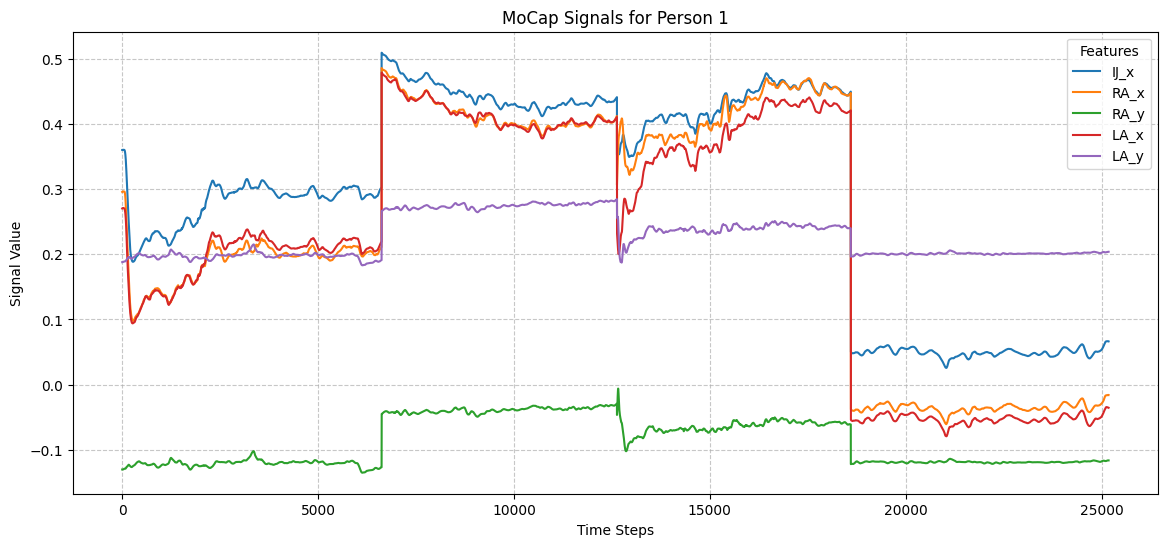

In [ ]:
mocap_person1 = mocap_df[mocap_df['people_id'] == 1]
mocap_features = ['IJ_x', 'RA_x', 'RA_y','LA_x','LA_y']

plt.figure(figsize=(14, 6))
for feature in mocap_features:
    plt.plot(mocap_person1.index, mocap_person1[feature], label=feature)
plt.title("MoCap Signals for Person 1")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()




Here we choose the features IJ_x, RA_x , RA_y, LA_x and LA_y.
IJ_x: represents the horizontal coordinates of the center point of the body (e.g., the midpoint of the clavicle), which reflects the overall movement and positional changes of the torso, and is a key datum for describing the whole-body movements.
RA_x and RA_y: represent the horizontal and vertical coordinates of the right arm, respectively. The right arm usually has a significant swing pattern in dynamic movements, and the trajectory of the right arm can be captured by these two features.
LA_x and LA_y: similar to the right arm features, they represent the horizontal and vertical coordinates of the left arm. The motion of the left arm can complement movement analysis, especially in symmetry and coordination assessment.
Horizontal (x-direction) and vertical (y-direction) are two important dimensions for describing movements, and the selection of these features provides a comprehensive picture of the spatial distribution of movements.
Directionality of movement analysis:
Horizontal features (IJ_x, RA_x, LA_x) are useful for analyzing forward and backward movement or body swing patterns.
Vertical features (RA_y, LA_y) can reveal the amplitude of movements such as arm lifting and dropping.
RA_x and LA_x, as well as RA_y and LA_y, can be used to compare the coordination and symmetry of left and right limb movements, which is critical in gait analysis or anomaly detection.
From the figure, we can observe


Dynamic phase: 0-6000 and 13000-18000 time periods, the feature fluctuation is more significant, indicating more active movements.
In the static phase: 6000-13000 and 18000-25000 time periods, the feature changes tend to stabilize, indicating that the movement is less or in a resting state.

# EDA after segmentaiton

## Load dataset

In [ ]:
from google.colab import drive
import pandas as pd


# path
raw_files = [
    '/content/drive/My Drive/method_2/aligned_datasets_emg.csv',
    '/content/drive/My Drive/method_2/aligned_datasets_ips.csv',
    '/content/drive/My Drive/method_2/aligned_datasets_imu.csv',
    '/content/drive/My Drive/method_2/aligned_datasets_mocap.csv'
]


def load_datasets(file_paths):
    datasets = {}
    for file_path in file_paths:
        try:
            # Extract the key part of the filename as a dictionary key
            dataset_name = file_path.split('/')[-1]
            df = pd.read_csv(file_path)
            datasets[dataset_name] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return datasets


raw_datasets = load_datasets(raw_files)


dataset_info = [{"Dataset Name": name, "Shape": df.shape, "Rows": df.shape[0], "Columns": df.shape[1]}
                for name, df in raw_datasets.items()]
dataset_info_df = pd.DataFrame(dataset_info)

print(dataset_info_df.head())


                 Dataset Name          Shape    Rows  Columns
0    aligned_datasets_emg.csv   (113446, 67)  113446       67
1    aligned_datasets_ips.csv  (113446, 685)  113446      685
2    aligned_datasets_imu.csv   (113446, 57)  113446       57
3  aligned_datasets_mocap.csv  (113446, 156)  113446      156


In [ ]:
al_emg_df = raw_datasets["aligned_datasets_emg.csv"]
print(al_emg_df.head())

   Unnamed: 0  R_Vlat_rms    R_RF_rms  R_ST_rms  R_TA_rms  L_Vlat_rms  \
0           0    3.154265  292.758180        65        38    3.696738   
1           1    3.677968  326.696778        69        37    4.208268   
2           2    3.800089  267.279053        50        26    3.798007   
3           3    3.374545  292.657471        61        39    4.385206   
4           4    4.138228  382.388306        64        34    3.381075   

     L_RF_rms  L_ST_rms  L_TA_rms  R_MG_rms  ...   R_MG_zc     R_LG_zc  \
0  282.788085        56        34  3.684881  ...  3.497438  229.110718   
1  287.722779        62        32  4.657688  ...  9.854272  394.674683   
2  264.962768        44        20  3.792937  ...  5.891582  253.179930   
3  314.007569        66        32  5.642971  ...  7.399809  394.473266   
4  289.837644        61        32  5.003856  ...  6.837258  340.795900   

   R_SOL_zc  R_IL_zc   L_MG_zc     L_LG_zc  L_SOL_zc  L_IL_zc  category  \
0        51       27  3.413615  145.62377

In [ ]:
al_imu_df = raw_datasets["aligned_datasets_imu.csv"]
print(al_imu_df.head())

   Unnamed: 0  Head_Acc_X_mean  Head_Acc_Y_mean  Head_Acc_Z_mean  \
0           0         8.904977         0.384233         4.042627   
1           1         8.932194         0.351909         4.096076   
2           2         8.815747         0.335551         4.130934   
3           3         8.806464         0.340593         4.196511   
4           4         8.825958         0.329816         4.230514   

   Head_Gyr_X_mean  Head_Gyr_Y_mean  Head_Gyr_Z_mean  Head_Roll_mean  \
0        -0.011431         0.014266        -0.003312      -12.650186   
1         0.003090         0.032560         0.018453      -12.710571   
2         0.012052         0.044186         0.031625      -12.830830   
3         0.011351         0.028329         0.028800      -12.935340   
4         0.006858         0.029847         0.023784      -13.026545   

   Head_Pitch_mean  Head_Yaw_mean  ...  R_F_Acc_Y_mean  R_F_Acc_Z_mean  \
0       -10.219978      30.065427  ...       -1.945828        9.028294   
1       -1

In [ ]:
al_ips_df = raw_datasets["aligned_datasets_ips.csv"]
print(al_ips_df.head())

   Unnamed: 0  0_mean  1_mean  2_mean  3_mean  4_mean  5_mean  6_mean  \
0           0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1           1     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           2     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           3     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           4     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

     7_mean  8_mean  ...  674_mean  675_mean  676_mean  677_mean  678_mean  \
0  1.606667     0.0  ...       0.0       0.0       0.0       0.0       0.0   
1  1.460000     0.0  ...       0.0       0.0       0.0       0.0       0.0   
2  1.460000     0.0  ...       0.0       0.0       0.0       0.0       0.0   
3  1.680000     0.0  ...       0.0       0.0       0.0       0.0       0.0   
4  1.606667     0.0  ...       0.0       0.0       0.0       0.0       0.0   

   679_mean  680_mean  681_mean  category  person_id  
0      1.12       0.0       0.0      

In [ ]:
al_mocap_df = raw_datasets["aligned_datasets_mocap.csv"]
print(al_mocap_df.head())

   Unnamed: 0  C7_mean_x  C7_mean_y  C7_mean_z  RA_mean_x  RA_mean_y  \
0           0   0.182445   0.023007   1.402115   0.295875  -0.130377   
1           1   0.182231   0.023087   1.402198   0.296074  -0.130325   
2           2   0.182379   0.022964   1.402230   0.296210  -0.130333   
3           3   0.182557   0.022945   1.402290   0.296361  -0.130337   
4           4   0.182692   0.022905   1.402271   0.296523  -0.130310   

   RA_mean_z  LA_mean_x  LA_mean_y  LA_mean_z  ...  L_LM_velocity_y  \
0   1.394484   0.270495   0.187968   1.399205  ...        -0.000554   
1   1.394413   0.270739   0.188166   1.399469  ...        -0.002312   
2   1.394380   0.270884   0.188148   1.399508  ...        -0.000166   
3   1.394363   0.271069   0.188148   1.399518  ...         0.000001   
4   1.394320   0.271170   0.188165   1.399493  ...         0.000018   

   L_LM_velocity_z  L_CAL_velocity_x  L_CAL_velocity_y  L_CAL_velocity_z  \
0        -0.000430         -0.000011      1.492492e-06         -

## Genral data Analysis

#### Class distribution across modalities

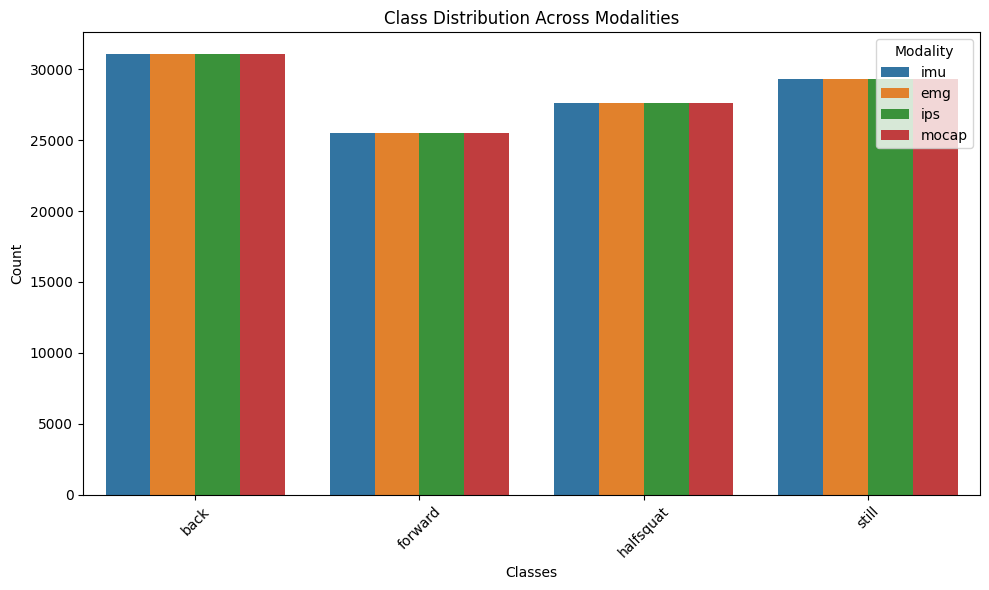

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data in DataFrame imu_df, emg_df, ips_df, mocap_df

al_imu_df['modality'] = 'imu'
al_emg_df['modality'] = 'emg'
al_ips_df['modality'] = 'ips'
al_mocap_df['modality'] = 'mocap'



all_data = pd.concat([al_imu_df, al_emg_df, al_ips_df, al_mocap_df], ignore_index=True)


if "category" not in all_data.columns:
    print("Error: 'category' column is missing in the combined dataset.")


plt.figure(figsize=(10, 6))
sns.countplot(data=all_data, x="category", hue="modality")
plt.title("Class Distribution Across Modalities")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.legend(title="Modality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The bar graphs represent the distribution of the four categories of samples (backward, forward, half-squat, and stationary) for each mode (imu, emg, ips, and mocap).
We can observe that comparing to the original data, for imu, emg, ips and mocap is that the data becomes balanced and the number of samples in each category is to be distributed consistently across the modes. This suggests that the feature extraction process is balanced, which may help maintain fairness in downstream tasks such as classification.

In [ ]:
print(f"Missing values in EMG dataset:\n{al_emg_df.isnull().sum()}")
print(f"Non-numeric columns in EMG dataset:\n{al_emg_df.select_dtypes(exclude=['number']).columns}")


Missing values in EMG dataset:
Unnamed: 0    0
R_Vlat_rms    0
R_RF_rms      0
R_ST_rms      0
R_TA_rms      0
             ..
L_SOL_zc      0
L_IL_zc       0
category      0
person_id     0
modality      0
Length: 68, dtype: int64
Non-numeric columns in EMG dataset:
Index(['category', 'modality'], dtype='object')


#### Modality distributions

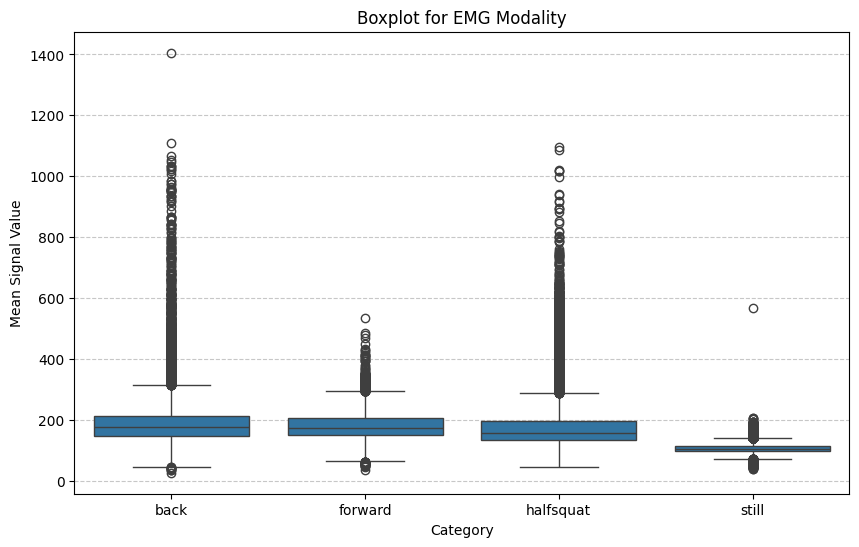

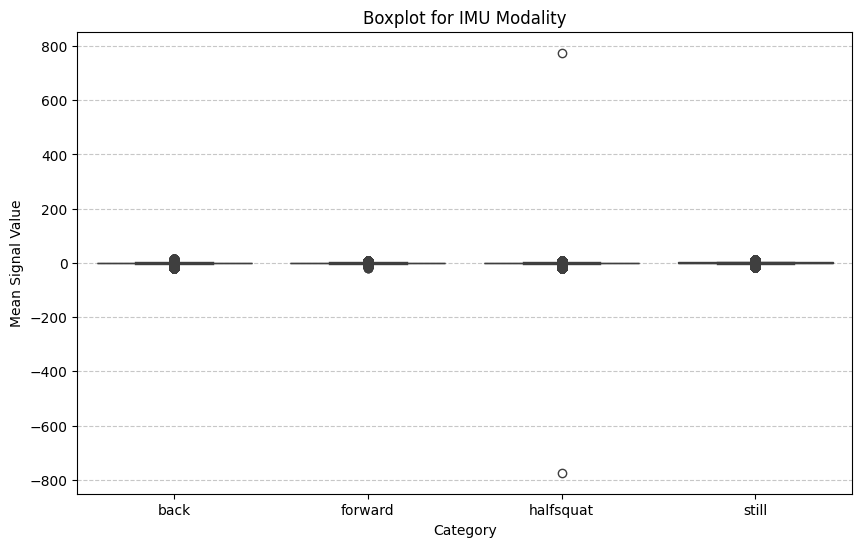

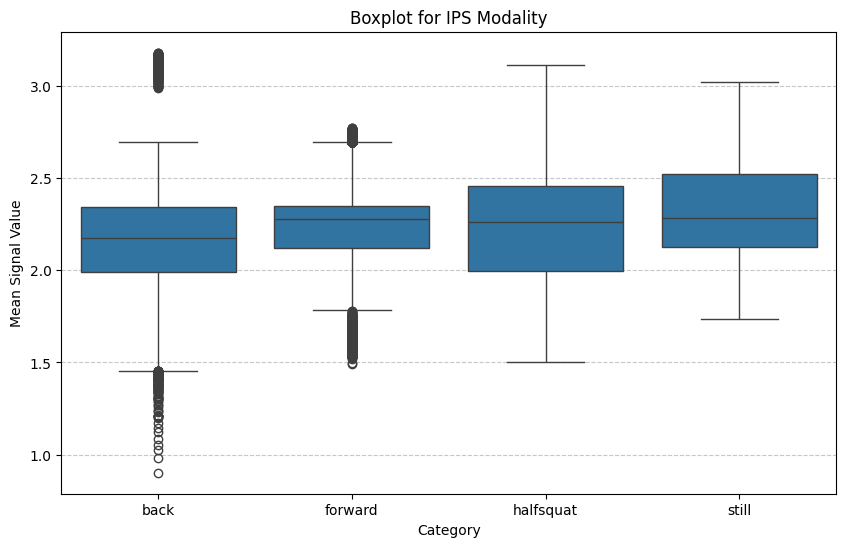

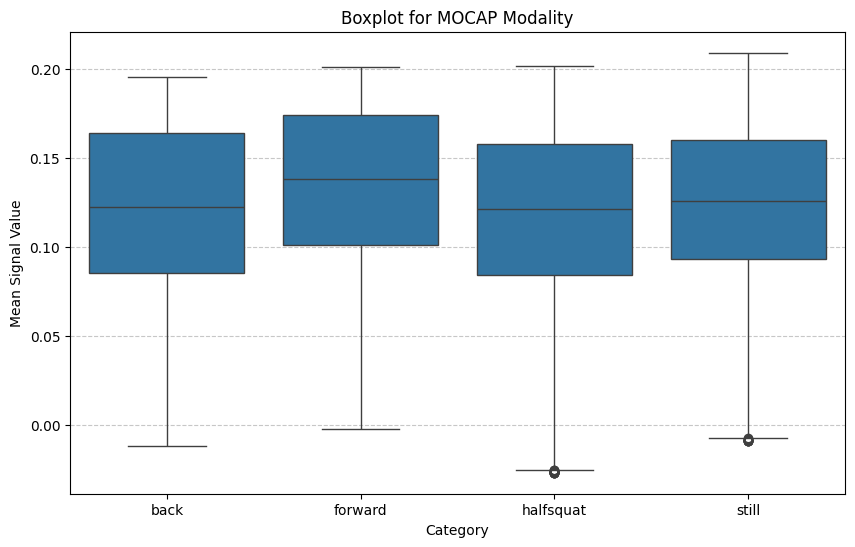

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting individual modal distributions
def plot_modality_distributions(modality_name, df):
    """
    Plotting the distribution of categories for a single modality (box-and-line plot)
    :param modality_name: modality name (string)
    :param df: dataset DataFrame (with people_id and category columns)
    """

    df['mean_signal'] = df.drop(['person_id', 'category','modality','Unnamed: 0'], axis=1).mean(axis=1)

    # box-and-line diagram
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='category', y='mean_signal')
    plt.title(f"Boxplot for {modality_name} Modality")
    plt.xlabel("Category")
    plt.ylabel("Mean Signal Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_modality_distributions("EMG", al_emg_df)
plot_modality_distributions("IMU", al_imu_df)
plot_modality_distributions("IPS", al_ips_df)
plot_modality_distributions("MOCAP", al_mocap_df)


Compared to the original data, we observe a significant reduction in the number of outliers. The sliding window approach smooths the signal by calculating statistical features, effectively reducing high-frequency fluctuations and noise.



At the same time, the central trend of the data becomes more pronounced. After applying the sliding window, the distribution of data between different categories is more distinct, indicating that the extracted statistical features enhance the separability between categories.



The statistical features derived from the sliding window capture the overall trend of the signal while eliminating short-term random variations. This process lays a solid foundation for training models with the refined data.

## Temporal visualisation for person with id 1



### EMG

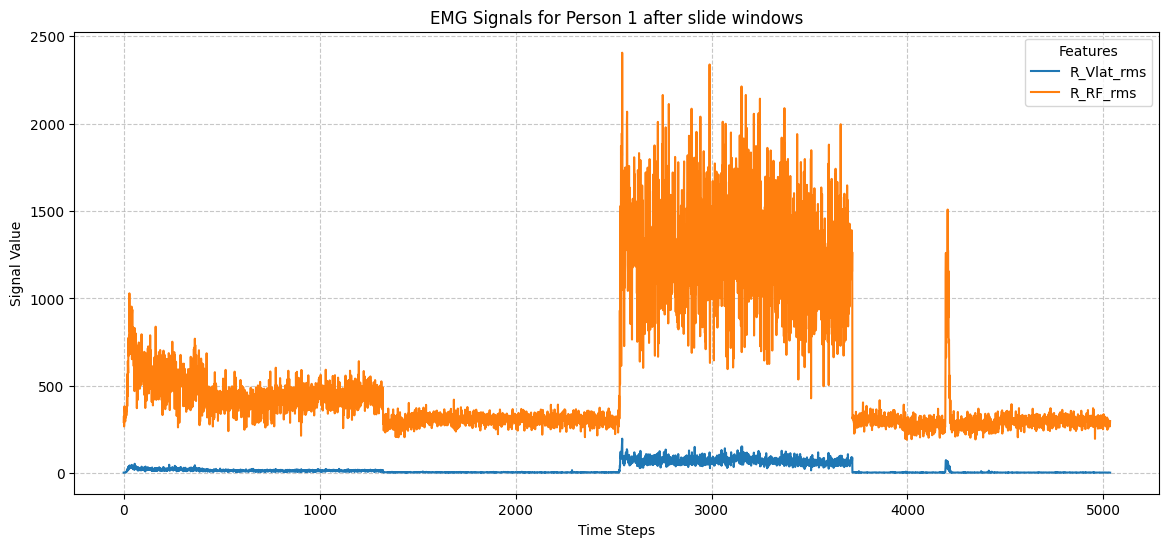

In [ ]:
# people_id = 1
al_emg_person1 = al_emg_df[al_emg_df['person_id'] == 1]

# features R_Vlat, R_RF
al_emg_features = ['R_Vlat_rms', 'R_RF_rms']


plt.figure(figsize=(14, 6))
for feature in al_emg_features:
    plt.plot(al_emg_person1.index, al_emg_person1[feature], label=feature)
plt.title("EMG Signals for Person 1 after slide windows")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Compared to the original data visualization, we can observe that the X-axis range has been reduced to 0-5000. The width and stride of the sliding window determine the time resolution of the output features. Unlike the original signal, the signal processed by the sliding window generates a new feature point at 50-millisecond intervals, significantly reducing the number of data points and narrowing the X-axis range.


The Y-axis trend remains consistent. RMS effectively captures the overall trend of the signal while filtering out short-term noise and high-frequency fluctuations.

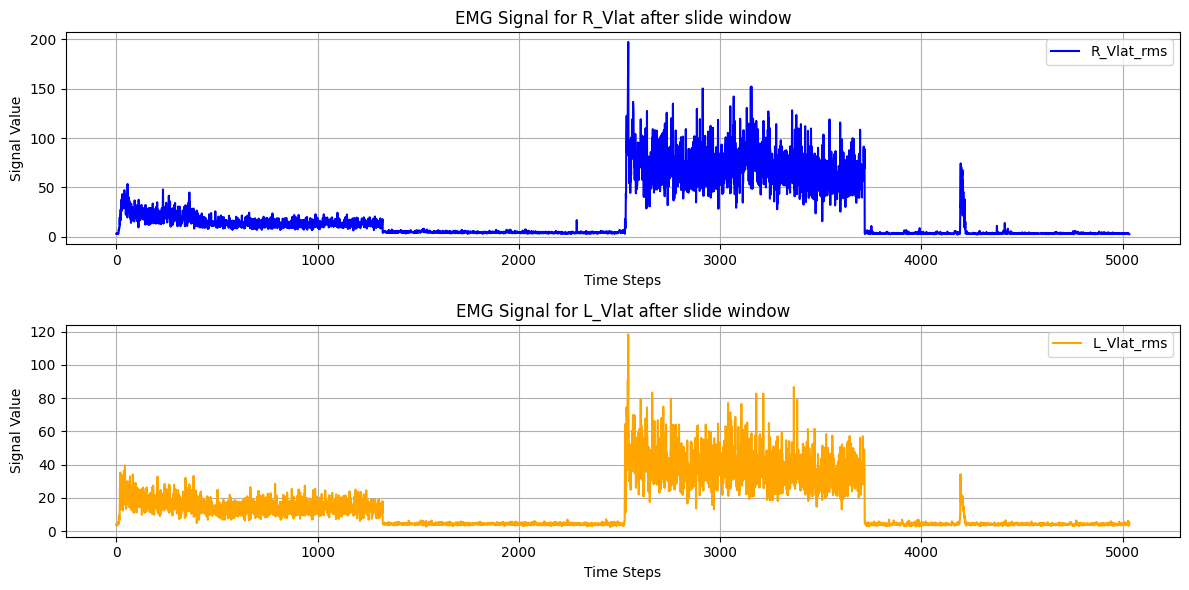

In [ ]:

plt.figure(figsize=(12, 6))

# R_Vlat
plt.subplot(2, 1, 1)
plt.plot(al_emg_person1.index, al_emg_person1['R_Vlat_rms'], color='blue', label='R_Vlat_rms')
plt.title('EMG Signal for R_Vlat after slide window')
plt.xlabel('Time Steps')
plt.ylabel('Signal Value')
plt.grid()
plt.legend()

# L_Vlat
plt.subplot(2, 1, 2)
plt.plot(al_emg_person1.index, al_emg_person1['L_Vlat_rms'], color='orange', label='L_Vlat_rms')
plt.title('EMG Signal for L_Vlat after slide window')
plt.xlabel('Time Steps')
plt.ylabel('Signal Value')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()



After sliding window processing, the X-axis range is reduced from the original signal's 500,000 to 5,000. The signal processed by the sliding window appears smoother, with short-term high-frequency fluctuations and noise significantly diminished, while the global trend of the signal is preserved.

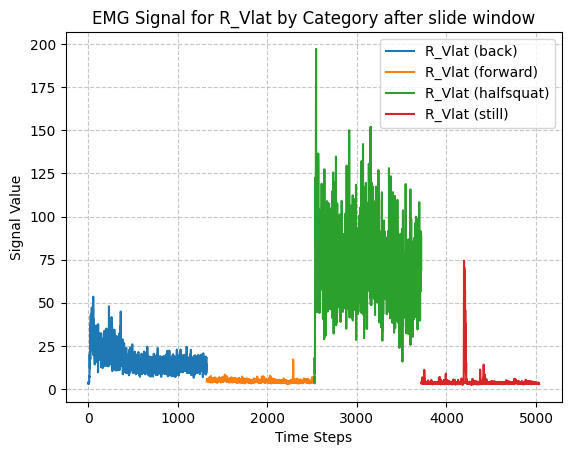

In [ ]:
for category in al_emg_person1['category'].unique():
    subset = al_emg_person1[al_emg_person1['category'] == category]
    plt.plot(subset.index, subset['R_Vlat_rms'], label=f"R_Vlat ({category})")
plt.title("EMG Signal for R_Vlat by Category after slide window")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

### IMU

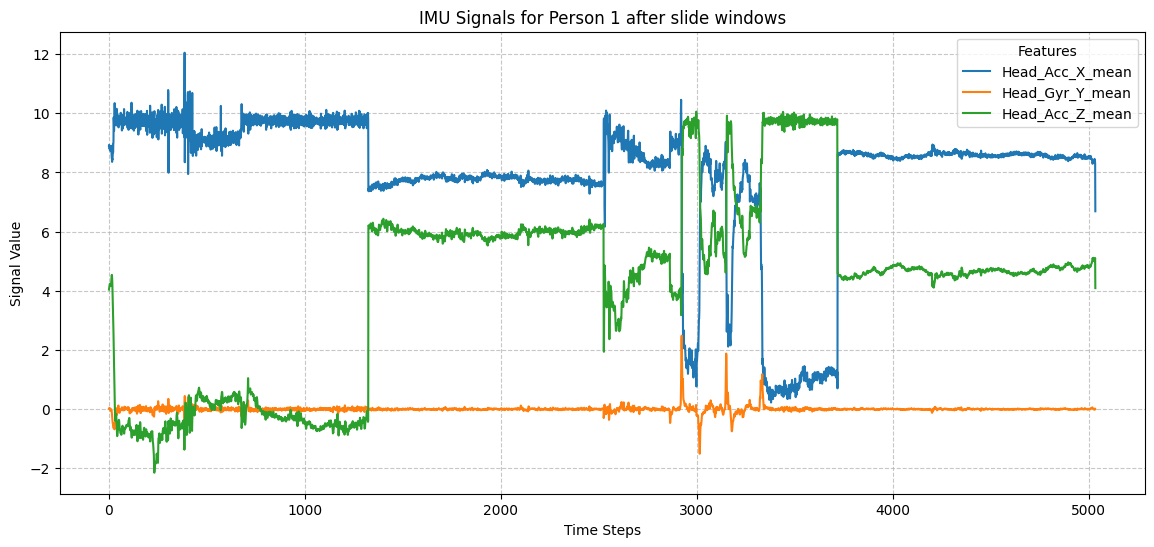

In [ ]:

al_imu_person1 = al_imu_df[al_imu_df['person_id'] == 1]

al_imu_features = ['Head_Acc_X_mean', 'Head_Gyr_Y_mean', 'Head_Acc_Z_mean']


plt.figure(figsize=(14, 6))
for feature in al_imu_features:
    plt.plot(al_imu_person1.index, al_imu_person1[feature], label=feature)
plt.title("IMU Signals for Person 1 after slide windows")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


In this figure, we can observe that the trends of Head_Acc_X_mean, Head_Gyr_Y_mean, and Head_Acc_Z_mean are consistent with the trends of Head_Acc_X, Head_Gyr_Y, and Head_Acc_Z before applying the sliding window. However, the range of the X-axis (time steps) in this figure is reduced compared to the original signal.

This is because the length of the features extracted by the sliding window is shorter than the original signal, due to the selected window size and step size.

### MoCap

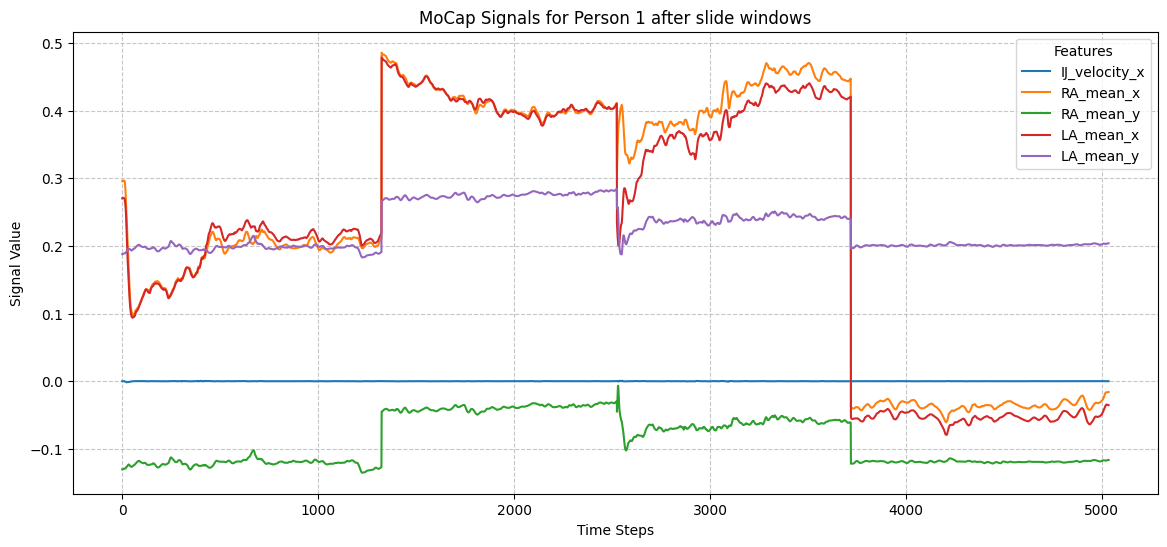

In [ ]:

al_mocap_person1 = al_mocap_df[al_mocap_df['person_id'] == 1]

al_mocap_features = ['IJ_velocity_x', 'RA_mean_x', 'RA_mean_y','LA_mean_x','LA_mean_y']


plt.figure(figsize=(14, 6))
for feature in al_mocap_features:
    plt.plot(al_mocap_person1.index, al_mocap_person1[feature], label=feature)
plt.title("MoCap Signals for Person 1 after slide windows")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend(title="Features", loc="upper right")
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Compared to the data before applying the sliding window, we can observe that the range of the X-axis is significantly smaller (0–5,000) after the sliding window operation. This reduction occurs because the sliding window samples and extracts features from the time series at a fixed step size, reducing the number of time steps with each shift.

However, the trends on the Y-axis remain consistent with those before applying the sliding window. This consistency indicates that the sliding window successfully captures the global information of the original signal through its extracted features.









# Prepare the data for modelisation

Once the data has been processed, we can proceed to the next step: preparing the data for model training. The data preparation process includes splitting the data into training and testing sets, normalizing the data, and converting the data into a format that can be fed into the model.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

We choose to work with the second method which consist of **Truncating Excess Data**,For example, if the EMG and IMU cover 10 seconds of recording, retain only the first 10 seconds of IPS data. Data was prepared on another notebook called `data_preparation`



In [ ]:
#/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/dataset/method_2
dataset_base_path = "/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/dataset/method_2"


df_emg = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_emg.csv"), index_col=0)
df_imu = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_imu.csv"), index_col=0)
df_ips = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_ips.csv"), index_col=0)
df_mocap = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_mocap.csv"), index_col=0)


In [ ]:
print(df_emg.shape)
df_emg.head(5)

(113446, 66)


R_Vlat_rms    R_RF_rms  R_ST_rms  R_TA_rms  L_Vlat_rms  \
Unnamed: 0                                                           
0             3.154265  292.758180        65        38    3.696738   
1             3.677968  326.696778        69        37    4.208268   
2             3.800089  267.279053        50        26    3.798007   
3             3.374545  292.657471        61        39    4.385206   
4             4.138228  382.388306        64        34    3.381075   

              L_RF_rms  L_ST_rms  L_TA_rms  R_MG_rms    R_LG_rms  ...  \
Unnamed: 0                                                        ...   
0           282.788085        56        34  3.684881  195.675659  ...   
1           287.722779        62        32  4.657688  368.994141  ...   
2           264.962768        44        20  3.792937  284.197999  ...   
3           314.007569        66        32  5.642971  368.893433  ...   
4           289.837644        61        32  5.003856  253.582763  ...   

             R_MG_zc     R_LG_zc  R_SOL_zc  R_IL_zc   L_MG_zc     L_LG_zc  \
Unnamed: 0                                                                  
0           3.497438  229.110718        51       27  3.413615  145.623779   
1           9.854272  394.674683        51       23  5.228666  243.411255   
2           5.891582  253.179930        35       12  4.752426  123.065186   
3           7.399809  394.473266        40       24  2.422399  159.622193   
4           6.837258  340.795900        52       32  4.945372  221.759034   

            L_SOL_zc  L_IL_zc  category  person_id  
Unnamed: 0                                          
0                 29       21      back          1  
1                 48       24      back          1  
2                 34       12      back          1  
3                 38       24      back          1  
4                 34       22      back          1  

[5 rows x 66 columns]

### Useful functions

#### Data treatement

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [ ]:
def load_data(emg_df, imu_df, ips_df, mocap_df, label_df):

    X0 = emg_df.iloc[:,:-2].values
    X1 = imu_df.iloc[:,:-2].values
    X2 = ips_df.iloc[:,:-2].values
    X3 = mocap_df.iloc[:,:-2].values
    y = label_df.category.values
    X = [X0, X1, X2, X3]
    return X, y

#### Normalised data

In [ ]:
from tqdm import tqdm

def load_and_normalize_data(emg_df, imu_df, ips_df, mocap_df, label_df):
    """
    Load and normalize the datasets.

    Parameters:
        emg_df (pd.DataFrame): EMG data.
        imu_df (pd.DataFrame): IMU data.
        ips_df (pd.DataFrame): IPS data.
        mocap_df (pd.DataFrame): Motion Capture data.
        label_df (pd.DataFrame): Labels for the data.

    Returns:
        list: Normalized feature arrays for EMG, IMU, IPS, and MOCAP data.
        np.ndarray: Labels for the data.
    """
    # Normalize each dataset using Min-Max scaling
    def normalize(df):
        return (df - df.min()) / (df.max() - df.min())

    print("Normalizing datasets...")

    # Apply normalization and extract values
    X0 = normalize(emg_df.iloc[:, :-1]).values  # Exclude label column if present
    X1 = normalize(imu_df.iloc[:, :-1]).values
    X2 = normalize(ips_df.iloc[:, :-1]).values
    X3 = normalize(mocap_df.iloc[:, :-1]).values
    y = label_df.category.values  # Extract labels

    print("Normalization complete.")

    # Combine into a list
    X = [X0, X1, X2, X3]
    return X, y


#### Evaluation class

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import tensorflow as tf

class Benchmark:
    def __init__(self, models, histories=None, models_name=None):
        """
        Initialize the Benchmark class.

        Args:
            models: List of trained models.
            histories: List of training history objects corresponding to each model (optional).
        """
        self.models = models
        self.histories = histories
        self.metrics = []

    def predict_classes(self, X_tests, y_test):
        """
        Generate predictions and predicted classes for each model.
        Stores y_pred and y_pred_classes for each model.

        Args:
            X_tests: List of test datasets matching the input format for each model.
            y_test: Ground truth labels for the test set.
        """
        self.y_preds = []
        self.y_pred_classes = []
        self.class_reports = []

        for i, model in enumerate(self.models):
            y_pred = model.predict(X_tests)
            y_pred_classes = np.argmax(y_pred, axis=-1)


            self.y_preds.append(y_pred)
            self.y_pred_classes.append(y_pred_classes)

            # Calculate evaluation metrics for the model
            accuracy = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall = recall_score(y_test, y_pred_classes, average='weighted')
            f1 = f1_score(y_test, y_pred_classes, average='weighted')

            self.metrics.append({
                'Model': f'Model_{models_name[i]}',
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

            # Add classification report for this model
            report = classification_report(y_test, y_pred_classes, output_dict=True)
            self.class_reports.append(report)

    def plot_confusion_matrices(self, y_test):
        """
        Plot confusion matrices for each model in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred_classes in enumerate(self.y_pred_classes):
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.subplot(num_models, 1, i + 1)
            sns.heatmap(
                cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test)
            )
            plt.title(f"Confusion Matrix for Model_{models_name[i]}")
            plt.xlabel("Predicted")
            plt.ylabel("True")

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_test):
        """
        Plot ROC curves for all models in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=self.y_preds[0].shape[-1])
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred in enumerate(self.y_preds):
            plt.subplot(num_models, 1, i + 1)
            for j in range(y_pred.shape[-1]):
                fpr, tpr, _ = roc_curve(y_test_binary[:, j], y_pred[:, j])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"Class {j} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
            plt.title(f"ROC Curve for Model_{models_name[i]}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

    def plot_training_histories(self):
        """
        Plot training and validation metrics for all models in separate subplots.
        """
        if not self.histories:
            print("No training histories provided.")
            return

        num_models = len(self.histories)
        plt.figure(figsize=(10, 3 * num_models))

        for i, history in enumerate(self.histories):
            # Plot Loss
            plt.subplot(num_models, 2, 2 * i + 1)
            plt.plot(history.history['loss'], label='Train Loss')
            if 'val_loss' in history.history:
                plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f"Loss for Model_{models_name[i]}")
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            plt.legend()

            # Plot Accuracy
            plt.subplot(num_models, 2, 2 * i + 2)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f"Accuracy for Model_{models_name[i]}")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.legend()

        plt.tight_layout()
        plt.show()

    def get_metrics_dataframe(self):
        """
        Create a DataFrame summarizing evaluation metrics for all models.

        Returns:
            DataFrame containing evaluation metrics for all models.
        """
        return pd.DataFrame(self.metrics)

    def print_classification_reports(self):
        """
        Print classification reports for each model.
        """
        for i, report in enumerate(self.class_reports):
            print(f"Classification Report for Model_{models_name[i]}:")
            print(pd.DataFrame(report).transpose())
            print("\n")


# Modelisation

In [ ]:
# merge data for unified model after train test splits
def merge_modalities(X_list):
    """
    The features of all modes are combined into an overall feature matrix.
    """
    return tf.concat(X_list, axis=-1)

In [ ]:
label_df = df_emg[['category']] # It is the same for imu, ips and moap
person_df = df_emg[['person_id']]
X, y = load_data(df_emg, df_imu, df_ips, df_mocap, label_df)

le = LabelEncoder()
y = le.fit_transform(y)

## Architecture Unified

### Prepare data for split

#### Train Test split of sckit learn 80%-20% repartition

In [ ]:
from sklearn.model_selection import train_test_split

dataloader = train_test_split(*X,y, test_size=0.2, random_state=42)

In [ ]:
num_categories = len(X)
X_train = [np.array(dataloader[i * 2]) for i in range(num_categories)]
X_test = [np.array(dataloader[i * 2 + 1]) for i in range(num_categories)]
y_train = np.array(dataloader[-2])
y_test = np.array(dataloader[-1])
X_train = merge_modalities(X_train)
X_test = merge_modalities(X_test)

In [ ]:
X_train.shape

TensorShape([90756, 953])

#### Leave-One-Group-Out (LOGO) repartition

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def logo_split(X_list, y, person_df, train_patients_count=20):
    """
    Splits data into training and testing sets based on patient IDs.

    Args:
        X_list: List of arrays, one for each modality.
        y: Array of labels.
        person_df: DataFrame containing the 'person_id' column.
        train_patients_count: Number of patients to include in the training set (default=20).

    Returns:
        X_train: Array for training data.
        X_test: Array for testing data.
        y_train: Labels for training data.
        y_test: Labels for testing data.
    """
    # Extract unique patient IDs and sort for consistency
    unique_patients = np.sort(person_df['person_id'].unique())

    # Split patients into train and test groups
    train_patients = unique_patients[:train_patients_count]
    test_patients = unique_patients[train_patients_count:]

    # Create masks for train and test
    train_mask = person_df['person_id'].isin(train_patients).values
    test_mask = person_df['person_id'].isin(test_patients).values

    # Split each modality separately based on the masks
    X_train = [X[train_mask] for X in X_list]
    X_test = [X[test_mask] for X in X_list]

    # Split labels
    y_train = y[train_mask]
    y_test = y[test_mask]

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
X_train = merge_modalities(X_train)
X_test = merge_modalities(X_test)

### Model preparition

In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2

def build_unified_model(input_shape, dropout_rate=0.3, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    """
    Architecture Unifiée
    """

    input_layer = Input(shape=(input_shape,), name="Unified_Input")


    x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(input_layer)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu')(x)


    output_layer = layers.Dense(4, activation='softmax')(x)  #4 catégories


    model = models.Model(inputs=input_layer, outputs=output_layer)


    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


### Run model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_unified_model(input_shape=X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Converting probabilities to prediction categories

#  Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7075 - loss: 4.9375 - val_accuracy: 0.9450 - val_loss: 0.7114
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9094 - loss: 0.7257 - val_accuracy: 0.9660 - val_loss: 0.3438
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9319 - loss: 0.4068 - val_accuracy: 0.9684 - val_loss: 0.2156
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9362 - loss: 0.3267 - val_accuracy: 0.9717 - val_loss: 0.2022
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9416 - loss: 0.2952 - val_accuracy: 0.9679 - val_loss: 0.1929
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9429 - loss: 0.2792 - val_accuracy: 0.9728 - val_loss: 0.1932
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9257 - loss: 0.3141 - val_accuracy: 0.9732 - val_loss: 0.1899
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9383 - loss: 

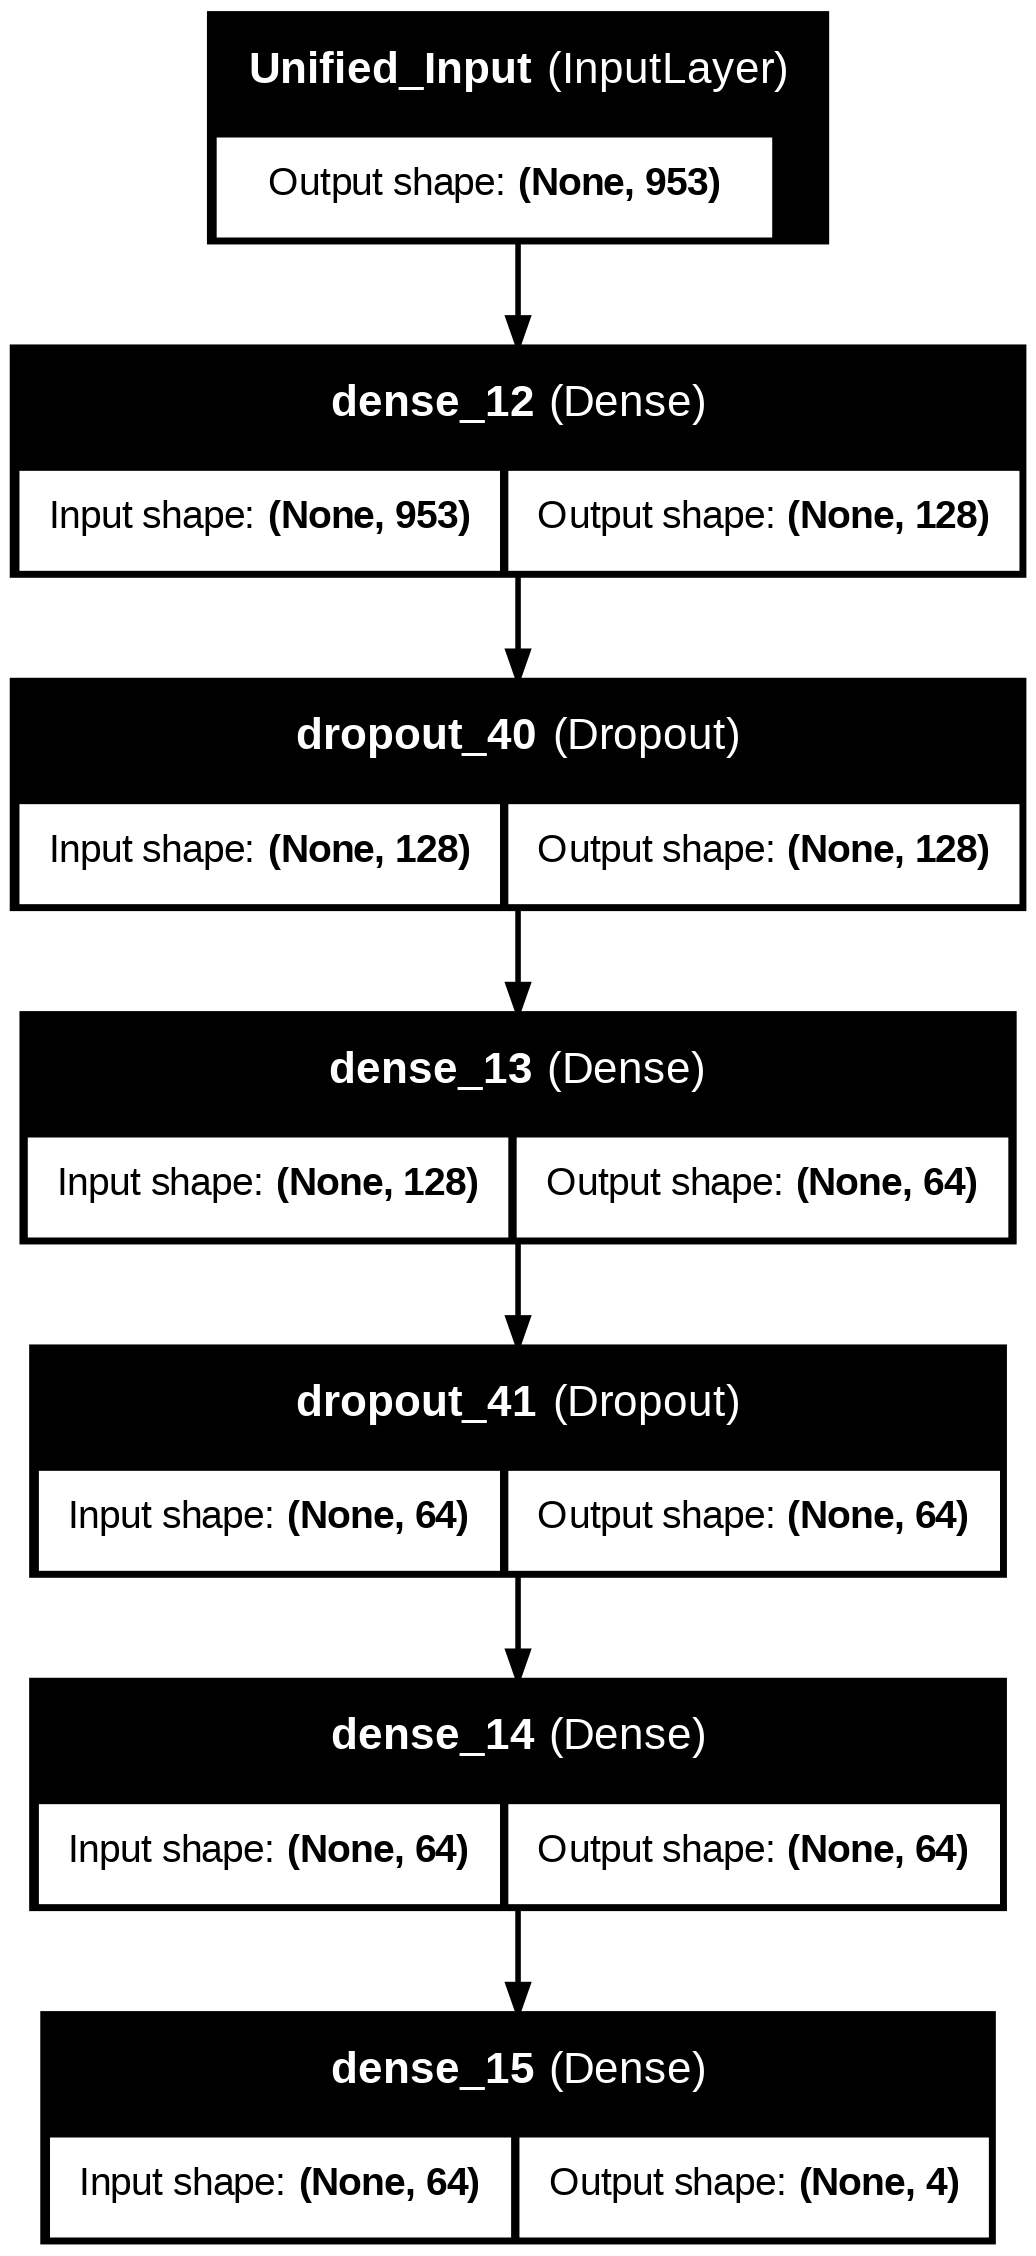

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Model Evaluation with train_test_split

In [ ]:
# Example models and datasets
models = [model]  # List of trained models
histories = [history] # List of training histories (optional)

models_name= ['Unified model', 'Unified model'] # List of model names
X_tests = X_test  # Test input datasets
y_test = y_test  # Ground truth labels

# Initialize Benchmark class
benchmark = Benchmark(models, histories, models_name)

In [ ]:

# Generate predictions
benchmark.predict_classes(X_tests, y_test)


592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Print classification reports
benchmark.print_classification_reports()

Classification Report for Model_Unified model:
              precision    recall  f1-score       support
0              0.985871  0.958623  0.972056   6187.000000
1              0.992404  0.985303  0.988840   5171.000000
2              0.979289  0.982892  0.981087   5436.000000
3              0.964004  0.994742  0.979132   5896.000000
accuracy       0.979903  0.979903  0.979903      0.979903
macro avg      0.980392  0.980390  0.980279  22690.000000
weighted avg   0.980101  0.979903  0.979883  22690.000000




In [ ]:

# Plot confusion matrices
benchmark.plot_confusion_matrices(y_test)


In [ ]:

# Plot ROC curves
benchmark.plot_roc_curves(y_test)


In [ ]:

# Plot training histories
benchmark.plot_training_histories()


In [ ]:
# Get metrics DataFrame
metrics_df = benchmark.get_metrics_dataframe()
metrics_df


Model  Accuracy  Precision    Recall  F1-Score
0  Model_Unified model  0.911572   0.922253  0.911572  0.909175

### Save Model

In [ ]:
import pickle

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Model Optimisation

#### Random Search

In [ ]:
import random
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import itertools

def random_search_unified_model(X, Y, split_methods,  hyperparameter_grid, n_samples=20):
    """
    Perform random search on the unified model.
    """
    results = []

    # Generate all combinations of hyperparameters
    all_hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    # Randomly sample n_samples combinations
    sampled_combinations = random.sample(all_hyperparameter_combinations, min(n_samples, len(all_hyperparameter_combinations)))

    # Iterate over split methods
    for split_method in split_methods:
        # Perform the split
        if split_method == "logo_split":
            X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
        else:
            X_ = merge_modalities(X)
            X_train, X_test, y_train, y_test = train_test_split(X_,y, test_size=0.2, random_state=42)
        # Iterate over sampled hyperparameter combinations
        for hyperparams in sampled_combinations:

            # Unpack hyperparameters
            hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparams))

            try:
                # Build and compile the model with the sampled hyperparameters
                model = build_unified_model(
                    input_shape=X_train.shape[1],
                    dropout_rate=hyperparam_dict['dropout_rate'],
                    optimizer=hyperparam_dict['optimizer'],
                    loss=hyperparam_dict['loss'],
                    metrics=hyperparam_dict['metrics']
                )

                # Early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    epochs=hyperparam_dict['epochs'],
                    batch_size=hyperparam_dict['batch_size'],
                    callbacks=[early_stopping],
                    verbose=0
                )

                # Record the results
                results.append({
                    'hyperparameters': hyperparam_dict,
                    'model_type': 'unified',
                    'split_method': split_method,
                    'accuracy': history.history['accuracy'][-1],

                })

            except Exception as e:
                print(f"Error with configuration {hyperparam_dict}: {e}")

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

# Define the hyperparameter grid
hyperparameter_grid = {
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'sgd'],
    'loss': ['sparse_categorical_crossentropy'],
    'metrics': [['accuracy']],
    'epochs': [8, 10],
    'batch_size': [32, 64],

}
split_methods = ["logo_split", "train_test_split"]
# Perform random search
results_df = random_search_unified_model(
    X, y, split_methods,
    hyperparameter_grid=hyperparameter_grid,
    n_samples=20
)


## Architectuer Multi-Modale

### Prepare data for split

#### Split data by categories

We tried to split the data in a way to respect the sequence of each category, without using train_test_split of sckit-learn



In [ ]:
def split_data_by_category(X, y, test_size=0.2):
    # Store the training data and labels
    X_train = []
    y_train = []
    X_test = []
    y_test = []


    # Convert categories to numeric labels based on the LabelEncoder
    category_labels = [0, 1, 2, 3]  # This is based on the ordering of the labels in LabelEncoder

    for category_label in  category_labels:
        # Filter data for the current category using the numeric label
        category_indices = np.where(y == category_label)[0]
        X_category = [x[category_indices] for x in X]
        y_category = y[category_indices]



        # Calculate the split index based on the test_size
        split_idx = int(len(X_category[0]) * (1 - test_size))  # Ensure the split respects time order

        # Split the data into training and testing sets for this category
        X_train_category = [x[:split_idx] for x in X_category]
        y_train_category = y_category[:split_idx]

        X_test_category = [x[split_idx:] for x in X_category]
        y_test_category = y_category[split_idx:]

        # Concatenate the training and testing data for each category
        X_train.append(X_train_category)
        y_train.append(y_train_category)
        X_test.append(X_test_category)
        y_test.append(y_test_category)



    # Concatenate the results across all categories
    X_train = [np.concatenate([X_train[i][j] for i in range(len(X_train))], axis=0) for j in range(len(X))]
    X_test = [np.concatenate([X_test[i][j] for i in range(len(X_test))], axis=0) for j in range(len(X))]

    y_train = [np.concatenate([y_train[i] for i in range(len(y_train))], axis=0)][0]
    y_test = [np.concatenate([y_test[i] for i in range(len(y_test))], axis=0)][0]

    return X_train, X_test, y_train, y_test

#### Functions to choose split method

In [ ]:
def preprocess_data_with_split(X, y, split_method, person_df=person_df, test_size=0.2, random_state=42):
    """
    Preprocess and split data using a specified split method, then reshape the results.

    Parameters:
    - X: List of numpy arrays or equivalent data to split (categories).
    - y: Target data to split.
    - split_method: String indicating the split method to use ("logo_split", "train_test_split", "split_data_by_category").
    - person_df: DataFrame for Leave-One-Group-Out split (required for "logo_split").
    - test_size: Proportion of test data for "train_test_split".
    - random_state: Random seed for "train_test_split".

    Returns:
    - Split and reshaped data: X_train, X_test, y_train, y_test.
    """
    if split_method == "logo_split":
        if person_df is None:
            raise ValueError("person_df must be provided for logo_split.")
        X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
    elif split_method == "train_test_split":
        dataloader = train_test_split(*X, y, test_size=test_size, random_state=random_state)
        num_categories = len(X)
        X_train = [np.array(dataloader[i * 2]) for i in range(num_categories)]
        X_test = [np.array(dataloader[i * 2 + 1]) for i in range(num_categories)]
        y_train = np.array(dataloader[-2])
        y_test = np.array(dataloader[-1])
    elif split_method == "split_data_by_category":
        X_train, X_test, y_train, y_test = split_data_by_category(X, y)
    else:
        raise ValueError(f"Unknown split method: {split_method}")

    # Reshape arrays
    X_train = [x.reshape(x.shape[0], 1, x.shape[1]) for x in X_train]
    X_test = [x.reshape(x.shape[0], 1, x.shape[1]) for x in X_test]

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="split_data_by_category", test_size=0.2, random_state=42
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)

# Use "train_test_split" method
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="train_test_split", test_size=0.2, random_state=42
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)



# Use "logo_split" method
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="logo_split", person_df=person_df
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)


X0_train shape: (90756, 1, 64)
X1_train shape: (90756, 1, 54)
X2_train shape: (90756, 1, 682)
y_train shape: (90756,)
X0_train shape: (90756, 1, 64)
X1_train shape: (90756, 1, 54)
X2_train shape: (90756, 1, 682)
y_train shape: (90756,)
X0_train shape: (94504, 1, 64)
X1_train shape: (94504, 1, 54)
X2_train shape: (94504, 1, 682)
y_train shape: (94504,)


### Model preparition

#### Simple model

In [ ]:
import tensorflow as tf
import numpy as np

def create_and_train_model(input_shapes, num_classes, dropout_rate=0.5,X_train=None,y_train=None,
                           kernel_regularizer=tf.keras.regularizers.l2(0.001), optimizer='adam',
                           metrics=['accuracy'],  validation_split=0.2, epochs=20, early_stopping = None):
    """
    Create and train a concatenated neural network model.

    Parameters:
        input_shapes (list of tuple): A list of input shapes for each input tensor.
        num_classes (int): Number of output classes for classification.
        dense_layers_config (list of dict): List of dense layer configurations, e.g., [{'units': 100, 'activation': 'relu'}, ...].
        dropout_rate (float): Dropout rate for regularization.
        kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizer for the Dense layers.
        optimizer (str or tf.keras.optimizers.Optimizer): Optimizer for training.
        loss (str or tf.keras.losses.Loss): Loss function for training.
        metrics (list): List of metrics to evaluate during training.
        X_train (list of np.ndarray): List of training input data arrays corresponding to input_shapes.
        y_train (np.ndarray): Training labels.
        validation_split (float): Fraction of training data to use as validation data.
        epochs (int): Number of training epochs.

    Returns:
        tf.keras.Model: The trained Keras model.
        tf.keras.callbacks.History: Training history object.
    """


    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'tanh'},
        {'units': 50, 'activation': 'tanh'}
    ]
    # Create input layers
    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    # Concatenate inputs along the last axis
    x = tf.keras.layers.concatenate(inputs, axis=-1)

    # Flatten the concatenated tensor
    x = tf.keras.layers.Flatten()(x)

    # Add dense layers with specified configurations
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Add output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Construct the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)

    # Display the model summary
    model.summary()

    # Plot the model architecture

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### CNN model

In [ ]:
def create_and_train_cnn_model(input_shapes, num_classes,
                               dropout_rate=0.5, X_train=None, y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                               optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]

    # Define convolutional layer configurations for the CNN model
    conv_layers_config = [
        {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3},
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3}
    ]
    # Apply convolutional layers to each input
    processed_inputs = []
    for input_tensor in inputs:
        x = input_tensor
        for layer_config in conv_layers_config:
            x = tf.keras.layers.Conv1D(
                filters=layer_config['filters'],
                kernel_size=layer_config['kernel_size'],
                activation=layer_config.get('activation', 'relu'),
                kernel_regularizer=kernel_regularizer,
                padding='same'
            )(x)

            if x.shape[1] > 1 and 'pool_size' in layer_config:
                x = tf.keras.layers.MaxPooling1D(pool_size=layer_config['pool_size'])(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        processed_inputs.append(tf.keras.layers.Flatten()(x))

    # Concatenate flattened outputs
    x = tf.keras.layers.concatenate(processed_inputs, axis=-1)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### LSTM model

In [ ]:
def create_and_train_lstm_model(input_shapes, num_classes,
                                dropout_rate=0.5,X_train=None,y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    """
    Create and train an LSTM-based model.

    Parameters:
        input_shapes (list of tuple): A list of input shapes for each input tensor.
        num_classes (int): Number of output classes for classification.
        lstm_layers_config (list of dict): List of LSTM layer configurations,
            e.g., [{'units': 64, 'return_sequences': True}, ...].
        dense_layers_config (list of dict): List of dense layer configurations.
        dropout_rate (float): Dropout rate for regularization.
        kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizer for the Dense layers.
        optimizer (str or tf.keras.optimizers.Optimizer): Optimizer for training.
        metrics (list): List of metrics to evaluate during training.
        validation_split (float): Fraction of training data to use as validation data.
        epochs (int): Number of training epochs.

    Returns:
        tf.keras.Model: The trained Keras model.
        tf.keras.callbacks.History: Training history object.
    """

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]


    # Define LSTM layer configurations for the LSTM model
    lstm_layers_config = [
        {'units': 64, 'return_sequences': True},
        {'units': 32, 'return_sequences': False}
    ]

    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]
    x = tf.keras.layers.concatenate(inputs, axis=-1)


    # Apply LSTM layers
    for layer_config in lstm_layers_config:
        x = tf.keras.layers.LSTM(
            units=layer_config['units'],
            return_sequences=layer_config.get('return_sequences', False),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### hybrid version of CNN and LSTM

In [ ]:
import tensorflow as tf

def create_and_train_cnn_lstm_model(input_shapes, num_classes,
                                    dropout_rate=0.5, X_train=None, y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, batch_size=32, early_stopping = None):


    # Define convolutional layer configurations for the hybrid model
    conv_layers_config = [
        {'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3},
    ]

    # Define LSTM layer configurations for the hybrid model
    lstm_layers_config = [
        {'units': 32, 'return_sequences': True},
    ]

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 64, 'activation': 'relu'},
        {'units': 32, 'activation': 'relu'}
    ]

    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    processed_inputs = []
    for input_tensor in inputs:
        x = input_tensor
        # Apply Conv1D layers
        for layer_config in conv_layers_config:
            x = tf.keras.layers.Conv1D(
                filters=layer_config['filters'],
                kernel_size=layer_config['kernel_size'],
                activation=layer_config.get('activation', 'relu'),
                kernel_regularizer=kernel_regularizer,
                padding='same'
            )(x)


            if x.shape[1] > 1 and 'pool_size' in layer_config:
                x = tf.keras.layers.MaxPooling1D(pool_size=layer_config['pool_size'])(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        # Apply LSTM layers
        for layer_config in lstm_layers_config:
            x = tf.keras.layers.LSTM(
                units=layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                kernel_regularizer=kernel_regularizer
            )(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        processed_inputs.append(tf.keras.layers.Flatten()(x))

    # Concatenate flattened outputs
    x = tf.keras.layers.concatenate(processed_inputs, axis=-1)

    # Apply Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Build model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train is not None and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


### Run model

#### simple model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Number of classes for the output
num_classes = len(np.unique(y_train))

# Call the function to create and train the model
model, history = create_and_train_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_27            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 1, 953)         │              0 │ input_layer_24[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_25[0][0],  │
│                           │                        │                │ input_layer_26[0][0],  │
│                           │                        │                │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 953)            │              0 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_158 (Dense)         │ (None, 100)            │         95,400 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_98 (Dropout)      │ (None, 100)            │              0 │ dense_158[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_159 (Dense)         │ (None, 50)             │          5,050 │ dropout_98[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_99 (Dropout)      │ (None, 50)             │              0 │ dense_159[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_160 (Dense)         │ (None, 4)              │            204 │ dropout_99[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,654 (393.18 KB)

 Trainable params: 100,654 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6677 - loss: 0.9480 - val_accuracy: 0.8742 - val_loss: 0.4224
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8229 - loss: 0.5559 - val_accuracy: 0.9067 - val_loss: 0.3415
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8570 - loss: 0.4744 - val_accuracy: 0.9024 - val_loss: 0.3382
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8484 - loss: 0.4804 - val_accuracy: 0.9112 - val_loss: 0.3086
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8615 - loss: 0.4570 - val_accuracy: 0.9219 - val_loss: 0.3052
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8490 - loss: 0.4851 - val_accuracy: 0.8949 - val_loss: 0.3431
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8536 - loss: 0.4683 - val_accuracy: 0.9155 - val_loss: 0.3009
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8661 - loss: 0.44

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#### CNN model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]


# Create the CNN model
cnn_model, cnn_history = create_and_train_cnn_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_29            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_30            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 1, 32)          │          6,176 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 1, 32)          │          5,216 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 1, 32)          │         65,504 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 1, 32)          │         14,720 │ input_layer_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_100 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_102 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_104 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_106 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_100[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_102[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_104[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_106[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_101 (Dropout)     │ (None, 1, 64)          │              0 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_103 (Dropout)

 Total params: 147,402 (575.79 KB)

 Trainable params: 147,402 (575.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.3617 - loss: 7.2493 - val_accuracy: 0.7407 - val_loss: 0.8970
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7807 - loss: 0.8484 - val_accuracy: 0.9723 - val_loss: 0.3224
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9460 - loss: 0.4464 - val_accuracy: 0.9924 - val_loss: 0.2101
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9650 - loss: 0.3095 - val_accuracy: 0.9951 - val_loss: 0.1582
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9718 - loss: 0.2461 - val_accuracy: 0.9957 - val_loss: 0.1355
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9713 - loss: 0.2240 - val_accuracy: 0.9949 - val_loss: 0.1270
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9728 - loss: 0.2124 - val_accuracy: 0.9942 - val_loss: 0.1189
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9748 - loss: 0

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True)

#### LSTM model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Define dense layer configurations
dense_layers_config = [
    {'units': 100, 'activation': 'relu'},
    {'units': 50, 'activation': 'relu'}
]


# Define LSTM layer configurations for the LSTM model
lstm_layers_config = [
    {'units': 64, 'return_sequences': True},
    {'units': 32, 'return_sequences': False}
]

# Create the LSTM model
lstm_model, history_lstm = create_and_train_lstm_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)



Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_33            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_34            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_35            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 1, 953)         │              0 │ input_layer_32[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_33[0][0],  │
│                           │                        │                │ input_layer_34[0][0],  │
│                           │                        │                │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 64)          │        260,608 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_110 (Dropout)     │ (None, 1, 64)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout_110[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_111 (Dropout)     │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_164 (Dense)         │ (None, 100)            │          3,300 │ dropout_111[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_112 (Dropout)     │ (None, 100)            │              0 │ dense_164[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_165 (Dense)         │ (None, 50)             │          5,050 │ dropout_112[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_113 (Dropout)     │ (None, 50)             │              0 │ dense_165[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_166 (Dense)         │ (None, 4)              │            204 │ dropout_113[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 281,578 (1.07 MB)

 Trainable params: 281,578 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5672 - loss: 1.0713 - val_accuracy: 0.8318 - val_loss: 0.5126
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7665 - loss: 0.6848 - val_accuracy: 0.8942 - val_loss: 0.3879
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7993 - loss: 0.6104 - val_accuracy: 0.8928 - val_loss: 0.3980
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8081 - loss: 0.5969 - val_accuracy: 0.8893 - val_loss: 0.4016
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7939 - loss: 0.6108 - val_accuracy: 0.8744 - val_loss: 0.4602
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7814 - loss: 0.6439 - val_accuracy: 0.9014 - val_loss: 0.3643
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.7935 - loss: 0.6201 - val_accuracy: 0.8993 - val_loss: 0.3694
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8130 - lo

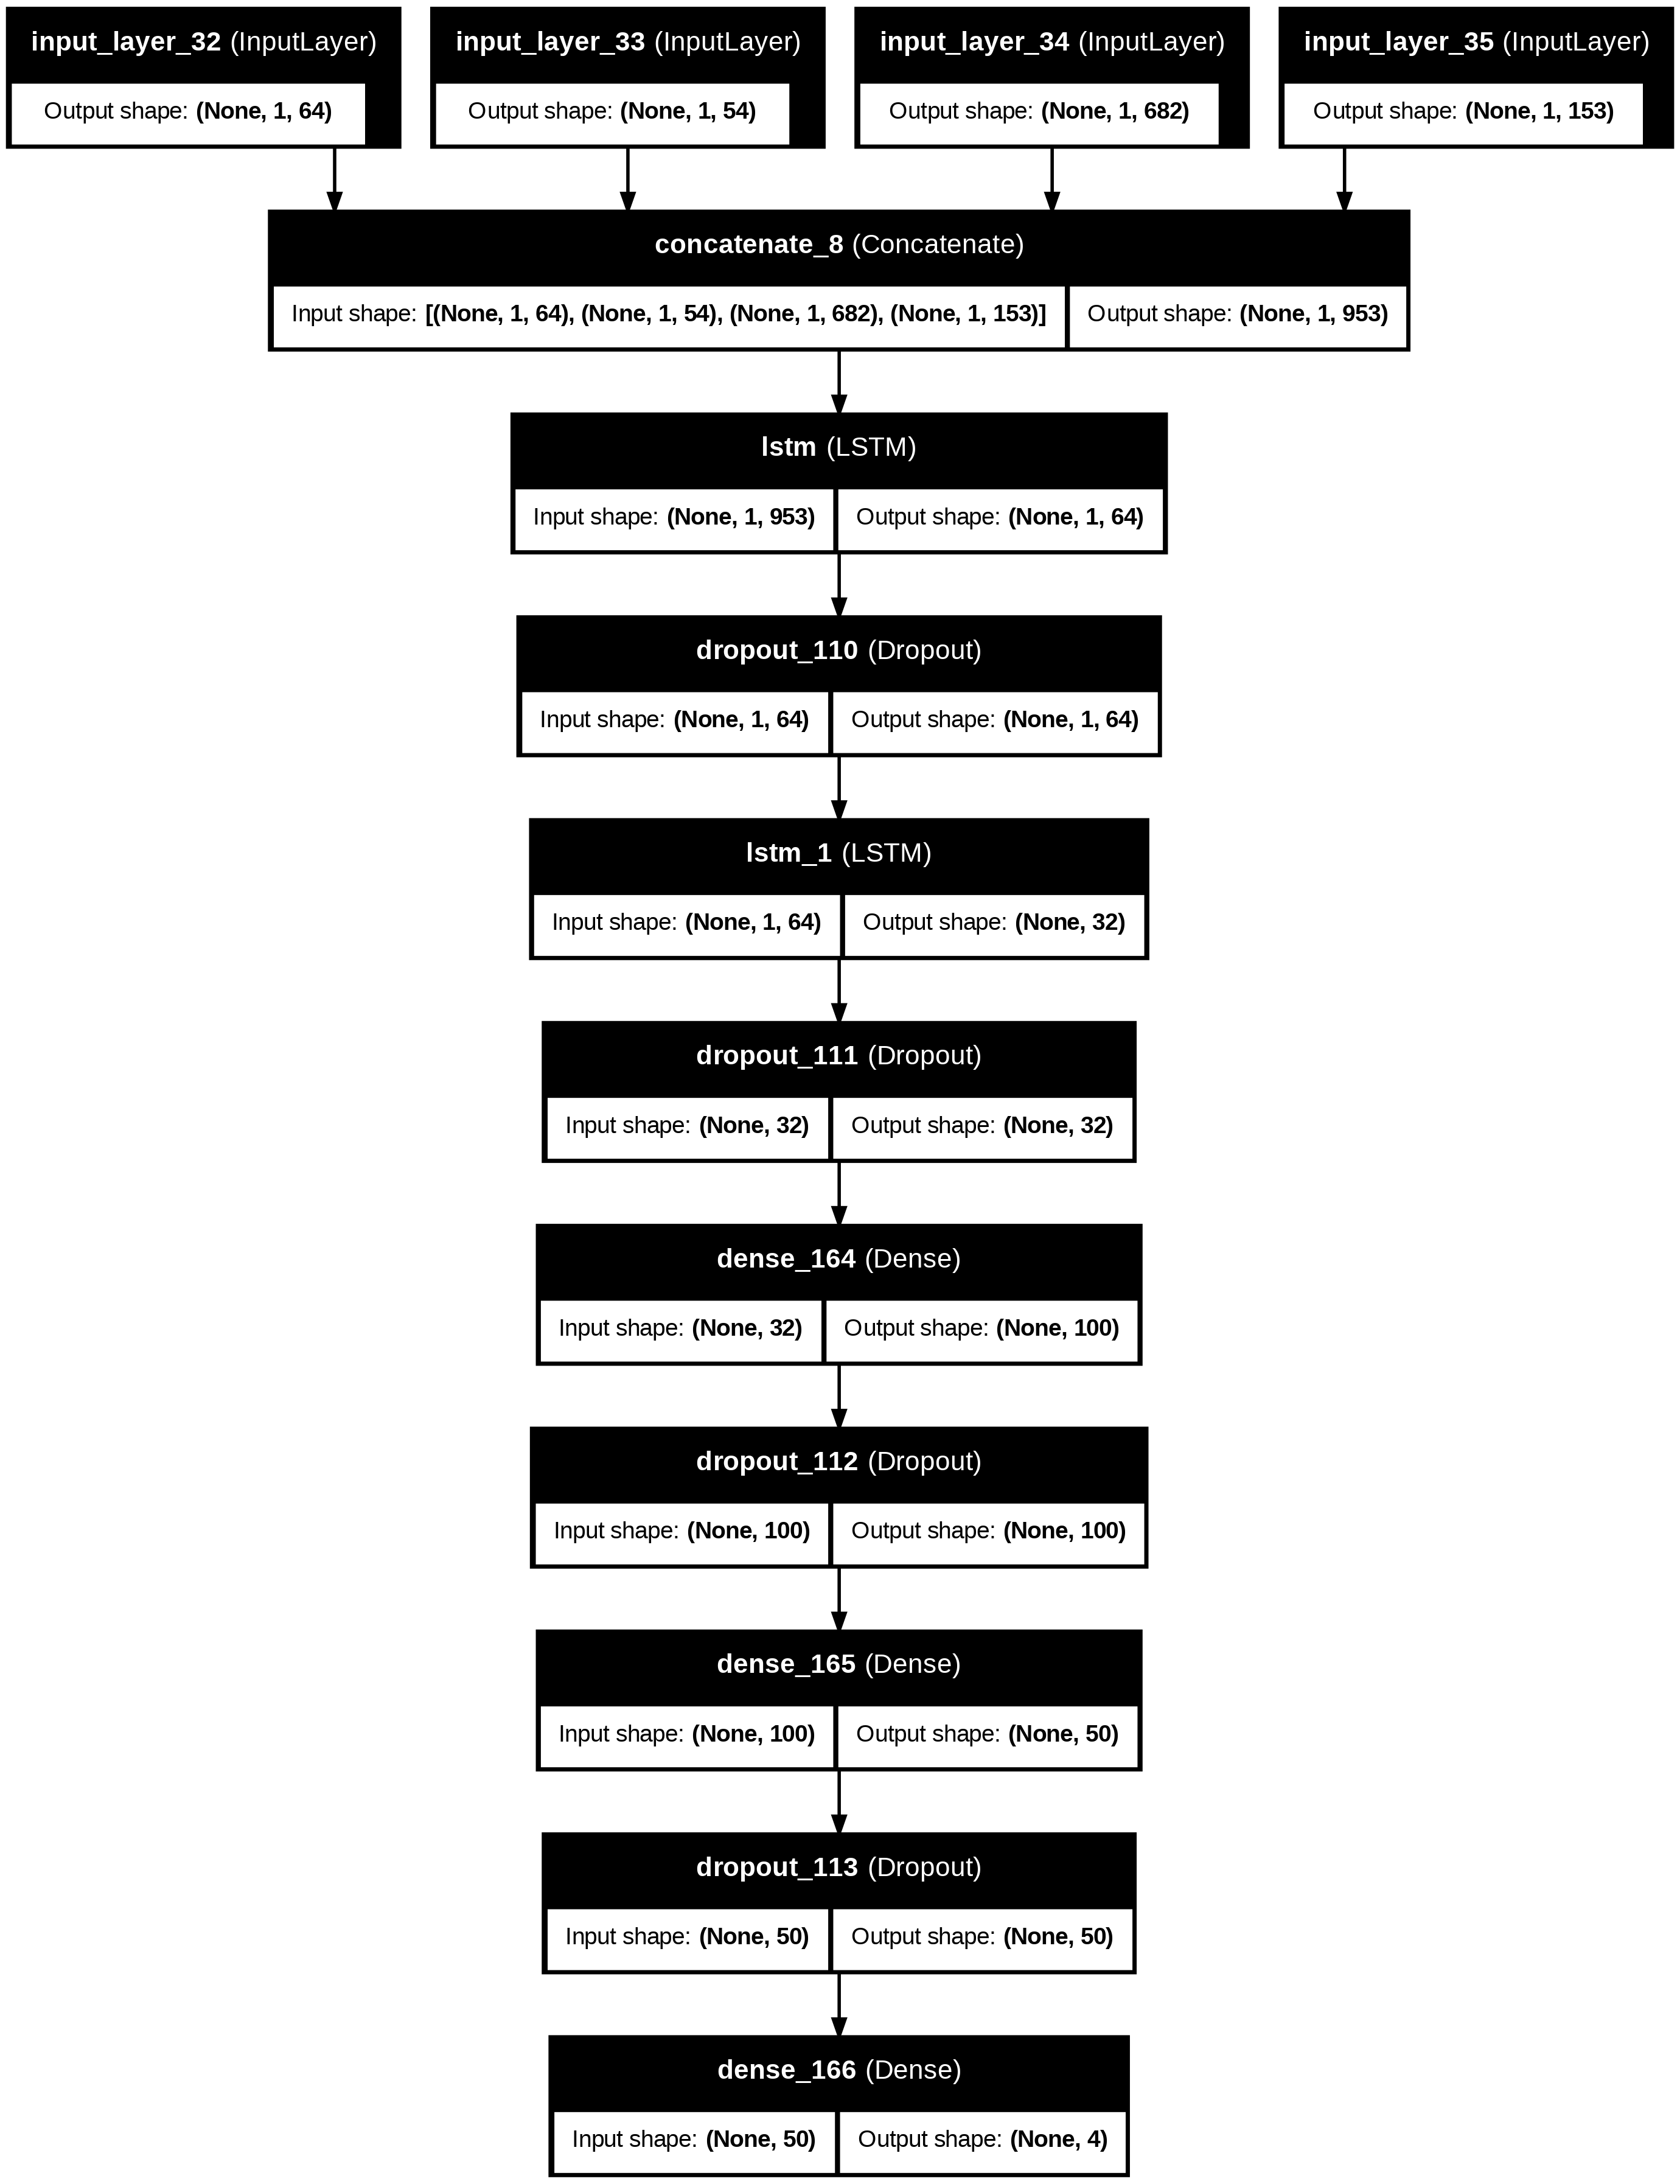

In [ ]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True, show_layer_names=True)

#### Hybrid version between of CNN and LSTM

In [ ]:
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Number of classes for the output
num_classes = len(np.unique(y_train))


# Create the hybrid CNN-LSTM model
hybrid_model, history_hybrid = create_and_train_cnn_lstm_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=8,
    batch_size=32,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 1, 16)          │          3,088 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 1, 16)          │          2,608 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_114 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_116 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_118 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_120 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_114[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_116[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_118[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_120[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_115 (Dropout)     │ (None, 1, 32)          │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_117 (Dropout)

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5755 - loss: 1.7431 - val_accuracy: 0.9839 - val_loss: 0.3028
Epoch 2/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9115 - loss: 0.5138 - val_accuracy: 0.9839 - val_loss: 0.2418
Epoch 3/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9302 - loss: 0.4265 - val_accuracy: 0.9902 - val_loss: 0.2073
Epoch 4/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9352 - loss: 0.3910 - val_accuracy: 0.9873 - val_loss: 0.1954
Epoch 5/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9380 - loss: 0.3778 - val_accuracy: 0.9896 - val_loss: 0.1911
Epoch 6/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9407 - loss: 0.3663 - val_accuracy: 0.9853 - val_loss: 0.2092
Epoch 7/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9406 - loss: 0.3607 - val_accuracy: 0.9852 - val_loss: 0.1956
Epoch 8/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9405 - loss: 0.3624 - 

In [ ]:
tf.keras.utils.plot_model(hybrid_model, show_shapes=True, show_layer_names=True)

### Model Evaluation with train_test_split

In [ ]:
# Example models and datasets
models = [model, cnn_model, lstm_model, hybrid_model]
histories = [history, cnn_history, history_lstm, history_hybrid]

models_name= ["Simple", "CNN", "LSTM","hybrid"]
X_tests = [X0_test, X1_test, X2_test, X3_test]  # Test input datasets
y_test = y_test  # Ground truth labels

# Initialize Benchmark class
benchmark = Benchmark(models, histories, models_name)

In [ ]:

# Generate predictions
benchmark.predict_classes(X_tests, y_test)


710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# Print classification reports
benchmark.print_classification_reports()

Classification Report for Model_Simple:
              precision    recall  f1-score       support
0              0.866367  0.902214  0.883927   6187.000000
1              0.992401  0.984916  0.988644   5171.000000
2              0.945946  0.843451  0.891763   5436.000000
3              0.914486  0.972185  0.942453   5896.000000
accuracy       0.925165  0.925165  0.925165      0.925165
macro avg      0.929800  0.925691  0.926697  22690.000000
weighted avg   0.926659  0.925165  0.924877  22690.000000


Classification Report for Model_CNN:
              precision    recall  f1-score       support
0              0.999190  0.996606  0.997896   6187.000000
1              0.999609  0.989557  0.994558   5171.000000
2              0.998526  0.997057  0.997791   5436.000000
3              0.986772  0.999491  0.993091   5896.000000
accuracy       0.995857  0.995857  0.995857      0.995857
macro avg      0.996024  0.995678  0.995834  22690.000000
weighted avg   0.995900  0.995857  0.995861  22690.

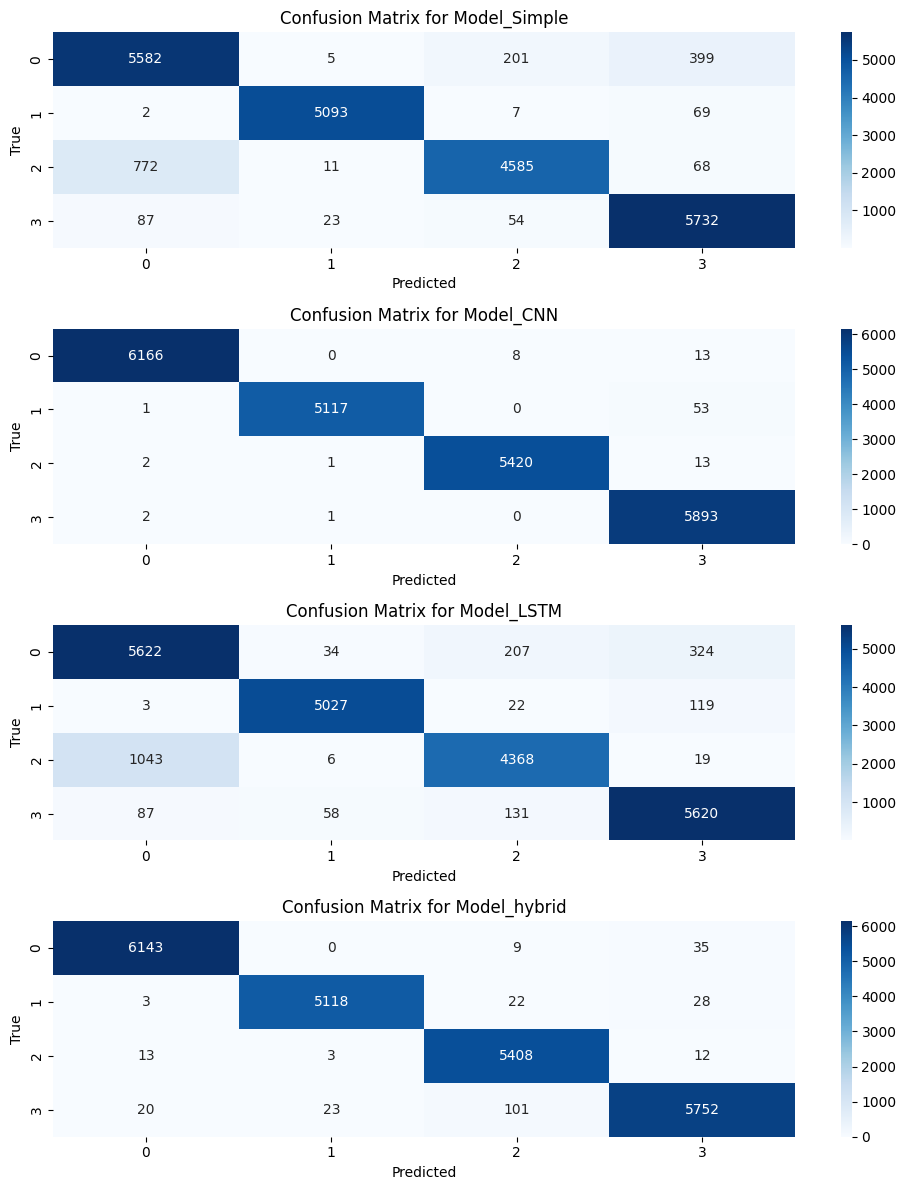

In [ ]:

# Plot confusion matrices
benchmark.plot_confusion_matrices(y_test)


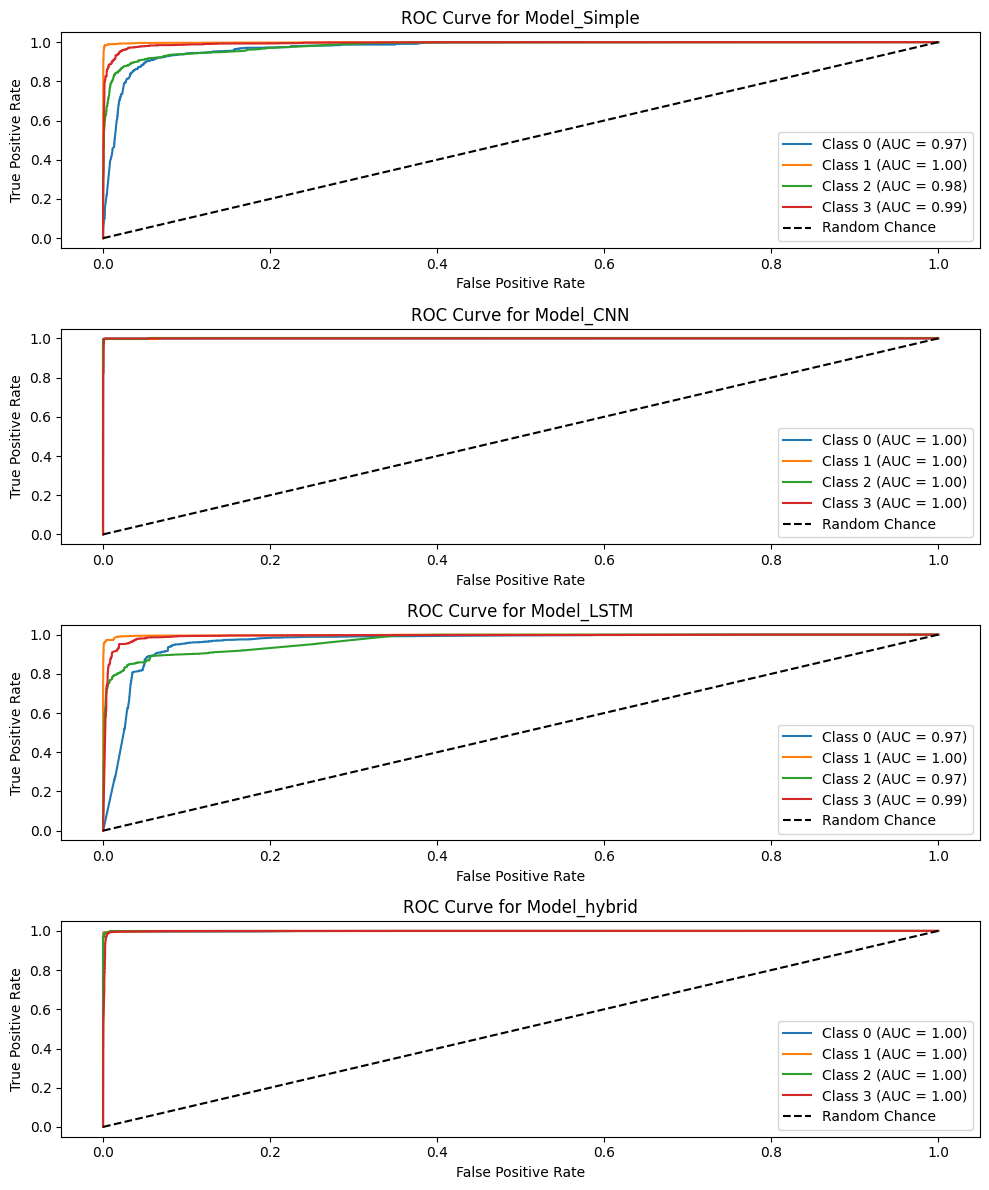

In [ ]:

# Plot ROC curves
benchmark.plot_roc_curves(y_test)


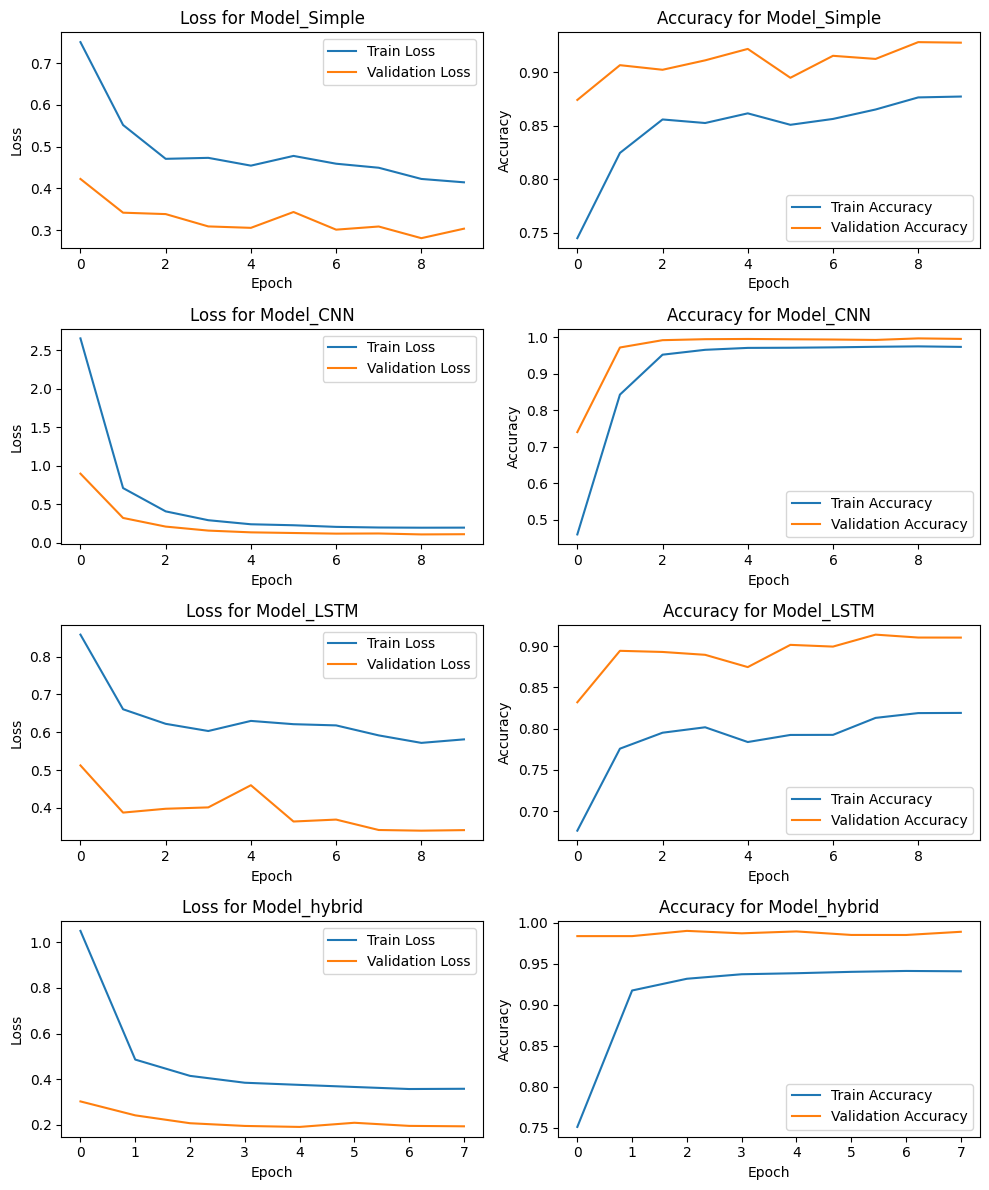

In [ ]:

# Plot training histories
benchmark.plot_training_histories()


### Save Model

In [ ]:
import pickle

# Save model
with open('multi_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Model Optimisation

#### Grid Search

In [ ]:
import itertools
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def grid_search(emg_df, imu_df, ips_df, mocap_df, label_df, person_df,
                split_methods, model_functions, normalization_options, hyperparameter_grid):
    # Results storage
    results = []
    models = []
    histories = []
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    # Iterate over normalization options
    for normalize in normalization_options:
        if normalize:
            X, y = load_and_normalize_data(emg_df, imu_df, ips_df, mocap_df, label_df)
            le = LabelEncoder()
            y = le.fit_transform(y)
        else:
            # Load data without normalization
            X, y = load_data(emg_df, imu_df, ips_df, mocap_df, label_df)
            le = LabelEncoder()
            y = le.fit_transform(y)

        # Iterate over split methods
        for split_method in split_methods:
            X_train, X_test, y_train, y_test = preprocess_data_with_split(X, y, split_method, person_df=person_df, test_size=0.2, random_state=42)

            # Get input shapes and number of classes
            input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

            # Number of classes for the output
            num_classes = len(np.unique(y_train))

            # Iterate over model functions (both CNN-LSTM hybrid and simple models)
            for model_func, model_type in model_functions:
                # Iterate over hyperparameter combinations
                for hyperparams in hyperparameter_combinations:
                    # Unpack hyperparameters for this configuration
                    hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparams))

                    # Train the hybrid model (CNN-LSTM)
                    try:
                        model, history = model_func(
                            input_shapes=input_shapes,
                            num_classes=num_classes,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),
                            dropout_rate=hyperparam_dict.get('dropout_rate', 0.5),
                            optimizer=hyperparam_dict.get('optimizer', 'adam'),
                            metrics=['accuracy'],
                            validation_split=0.2,
                            epochs=hyperparam_dict.get('epochs', 8),
                            batch_size=hyperparam_dict.get('batch_size', 32),
                            X_train=[X_train[0], X_train[1], X_train[2], X_train[3]],
                            y_train=y_train
                        )
                        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

                        # Store results for hybrid model
                        results.append({
                            "normalize": normalize,
                            "split_method": split_method,
                            "model_function": model_func,
                            "model_type": model_type,
                            "hyperparameters": hyperparam_dict,
                            "test_loss": test_loss,
                            "test_accuracy": test_accuracy,
                            "model" : model,
                            "history" : history
                        })

                    except Exception as e:
                        print(f"Error with hybrid model configuration: {hyperparam_dict}, Error: {e}")


    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

# Example Usage
split_methods = ["logo_split"]
model_functions = [
    (create_and_train_model, "simple") ,
    (create_and_train_cnn_model, "CNN"),
    (create_and_train_lstm_model, "LSTM"),
     (create_and_train_cnn_lstm_model, "hybrid"),
]
normalization_options = [True]
hyperparameter_grid = {
    "dropout_rate": [0.3],
    "optimizer": ['adam', 'sgd'],
    "epochs": [10],
    "batch_size": [16, 32]
}

results_df = grid_search(df_emg, df_imu, df_ips, df_mocap, label_df, person_df,
                         split_methods, model_functions, normalization_options, hyperparameter_grid)

# Analyze results
print(results_df.sort_values(by="test_accuracy", ascending=False))

Normalizing datasets...
Normalization complete.
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'sgd', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'sgd', 'epochs': 10, 'batch_size': 32}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_cnn_model() got an unexpected keywo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 64)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1, 16)          │          3,088 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 1, 16)          │         32,752 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 1, 16)          │          7,360 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1, 16)          │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 32)          │          6,272 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 32)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1, 32)          │              0 │ lstm_1[0][0]           │
├──────────────────────

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.2788 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2789 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2757 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2757 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.2737 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 1, 16)          │          3,088 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 1, 16)          │         32,752 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 1, 16)          │          7,360 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.2726 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2758 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2749 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2765 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.2775 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2772 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2745 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 1, 16)          │          3,088 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.2756 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2729 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2773 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2741 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2777 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2755 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 1, 16)          │          3,088 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 1, 16)          │          2,608 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.2740 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2706 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2715 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2765 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


In [ ]:
results_df.to_csv(dataset_base_path+'/results_df_version_2.csv', index=False)

# Benchmark

#### Global Performance

In [ ]:
metrics_df_cat_split = pd.read_csv(dataset_base_path+'/metrics_df_cat_split.csv')
metrics_df_logo_split = pd.read_csv(dataset_base_path+'/metrics_df_logo_split.csv')
metrics_df_logo_split_person = pd.read_csv(dataset_base_path+'/metrics_df_train_test_split.csv')
metrics_df_unified= pd.read_csv(dataset_base_path+'/metrics_df_version_2_unified_model.csv')

# concat data
metrics_df = pd.concat([metrics_df_cat_split, metrics_df_logo_split, metrics_df_logo_split_person, metrics_df_unified])
metrics_df.sort_values(by='Accuracy', ascending=False)

Model  Accuracy  Precision    Recall  F1-Score  \
1            Model_CNN  0.991847   0.991874  0.991847  0.991848   
3         Model_Hybrid  0.981666   0.981858  0.981666  0.981696   
0         Model_Simple  0.975804   0.975976  0.975804  0.975794   
2           Model_LSTM  0.927766   0.929040  0.927766  0.927575   
0  Model_Unified model  0.911572   0.922253  0.911572  0.909175   
2           Model_LSTM  0.858991   0.865370  0.858991  0.857143   
0         Model_Simple  0.852497   0.869468  0.852497  0.853371   
0         Model_Simple  0.804187   0.816856  0.804187  0.801923   
2           Model_LSTM  0.733230   0.784563  0.733230  0.729867   
3         Model_Hybrid  0.732077   0.842518  0.732077  0.720447   
1            Model_CNN  0.630609   0.809170  0.630609  0.626258   
3         Model_Hybrid  0.606435   0.691229  0.606435  0.547579   
1            Model_CNN  0.605024   0.674787  0.605024  0.558293   
1  Model_Unified model  0.271883   0.189576  0.271883  0.210248   

             split_method  
1        train_test_split  
3        train_test_split  
0        train_test_split  
2        train_test_split  
0        train_test_split  
2              logo_split  
0              logo_split  
0  split_data_by_category  
2  split_data_by_category  
3              logo_split  
1              logo_split  
3  split_data_by_category  
1  split_data_by_category  
1              logo_split

**The model that performed the best is the CNN multimodal model when the data is shuffled with train_test_split method, and the LSTM model for the logo split.**

#### Grid Search Results for the multimodal

In [ ]:
metrics_df_hybrid_grid_search = pd.read_csv(dataset_base_path+'/results_df_grid_search.csv', index_col=0)
metrics_df_hybrid_grid_search[:-2].head()

normalize split_method                                     model_function  \
0       True   logo_split  <function create_and_train_cnn_lstm_model at 0...   
1       True   logo_split  <function create_and_train_cnn_lstm_model at 0...   
2       True   logo_split  <function create_and_train_cnn_lstm_model at 0...   
3       True   logo_split  <function create_and_train_cnn_lstm_model at 0...   
4       True   logo_split  <function create_and_train_cnn_lstm_model at 0...   

  model_type                                    hyperparameters  test_loss  \
0     hybrid  {'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...        NaN   
1     hybrid  {'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...        NaN   
2     hybrid  {'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...        NaN   
3     hybrid  {'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...        NaN   
4     hybrid  {'dropout_rate': 0.3, 'optimizer': 'sgd', 'epo...        NaN   

   test_accuracy                                        model  \
0       0.269982  <Functional name=functional_16, built=True>   
1       0.269982  <Functional name=functional_17, built=True>   
2       0.269982  <Functional name=functional_18, built=True>   
3       0.269982  <Functional name=functional_19, built=True>   
4       0.269982  <Functional name=functional_20, built=True>   

                                             history  
0  <keras.src.callbacks.history.History object at...  
1  <keras.src.callbacks.history.History object at...  
2  <keras.src.callbacks.history.History object at...  
3  <keras.src.callbacks.history.History object at...  
4  <keras.src.callbacks.history.History object at...

#### Grid Search Results for the unified model

In [ ]:
metrics_df_unified_grid_search = pd.read_csv(dataset_base_path+'/results_df_version_1_unified_model.csv', )

history  \
hyperparameters                                                                                         
{'dropout_rate': 0.5, 'optimizer': 'adam', 'los...  <keras.src.callbacks.history.History object at...   
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...  <keras.src.callbacks.history.History object at...   
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...  <keras.src.callbacks.history.History object at...   
{'dropout_rate': 0.2, 'optimizer': 'sgd', 'loss...  <keras.src.callbacks.history.History object at...   
{'dropout_rate': 0.5, 'optimizer': 'sgd', 'loss...  <keras.src.callbacks.history.History object at...   

                                                                                         model  \
hyperparameters                                                                                  
{'dropout_rate': 0.5, 'optimizer': 'adam', 'los...  <Functional name=functional_1, built=True>   
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...  <Functional name=functional_2, built=True>   
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...  <Functional name=functional_3, built=True>   
{'dropout_rate': 0.2, 'optimizer': 'sgd', 'loss...  <Functional name=functional_4, built=True>   
{'dropout_rate': 0.5, 'optimizer': 'sgd', 'loss...  <Functional name=functional_5, built=True>   

                                                   model_type split_method  
hyperparameters                                                             
{'dropout_rate': 0.5, 'optimizer': 'adam', 'los...    unified   logo_split  
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...    unified   logo_split  
{'dropout_rate': 0.2, 'optimizer': 'adam', 'los...    unified   logo_split  
{'dropout_rate': 0.2, 'optimizer': 'sgd', 'loss...    unified   logo_split  
{'dropout_rate': 0.5, 'optimizer': 'sgd', 'loss...    unified   logo_split